# Estimating RSSNR with Bayesian Linear Regression

In [1]:
! conda install -c conda-forge "pymc>=5"

Retrieving notices: done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.0
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - pymc[version='>=5']


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       3_kmp_llvm           7 KB  conda-forge
    arviz-0.21.0               |     pyhd8ed1ab_0         1.4 MB  conda-forge
    atk-1.0-2.38.0             |       h04ea711_2         348 KB  conda-forge
    binutils_impl_linux-64-2.43|       h4bf12b8_2         5.4 MB  conda-forge
    binutils_linux-64-2.43     |       h4852527_2          34 KB  conda-forge
    blas-2.131                 |         openblas       

In [1]:
pip install corner

  Using cached corner-2.2.3-py3-none-any.whl.metadata (2.2 kB)
Using cached corner-2.2.3-py3-none-any.whl (15 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr

In [3]:
import pymc as pm
import corner
import arviz as az

In [4]:
from scipy.optimize import minimize

In [5]:
import pickle

In [6]:
def combo_scaler(x, range_max=2):
    median_x = np.median(x)
    iqr_x = np.percentile(x,75) - np.percentile(x,25)
    robust_x = ((x-median_x)/iqr_x)

    return (((robust_x - np.nanmin(robust_x)) / (np.nanmax(robust_x) - np.nanmin(robust_x))) * range_max)-1

In [7]:
def minmax_scaler(x, range_max=1):
    scaled_x = (((x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))) * range_max)

    return scaled_x

## Model Exploration on Texas Data

### Import the Texas Data
Bring in the data from the netcdf. We're going to run two regressions, based on the initial paper:

"We use separate linear regression models for grounded and floating ice, as determined by the BedMachine Antarctica mask."

In [100]:
data = xr.open_dataset('external_datasets/snr_data_utig_ais_with_inputs.nc')

In [101]:
texas_df = data.to_dataframe()

In [129]:
variable_df = texas_df.loc[(~np.isnan(texas_df['snr'])) & 
                           (~np.isnan(texas_df['thickness'])) &
                           (~np.isnan(texas_df['speed'])) &
                           (~np.isnan(texas_df['t2m'])) &
                           (~np.isnan(texas_df['surface'])) &
                           (~np.isnan(texas_df['bm_mask']))
                          ]

In [130]:
variable_df['log_speed'] = np.log(variable_df['speed'])

/tmp/ipykernel_111/311074380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variable_df['log_speed'] = np.log(variable_df['speed'])


In [131]:
variable_df = variable_df[~np.isinf(variable_df['log_speed'])]

In [132]:
grounded_texas_df = variable_df.loc[variable_df['bm_mask']==2]

In [133]:
grounded_df = variable_df.loc[variable_df['bm_mask']==2]

In [134]:
len(grounded_df)

1071291

In [135]:
grounded_df.columns

Index(['Unnamed: 0', 'snr', 'x', 'y', 'thickness', 'thickness_err', 'bm_mask',
       'surface', 'speed', 'speed_err', 't2m', 't2m_err', 'log_speed'],
      dtype='object')

### Norm the Texas Columns of Interest

For now, we'll start with thickness and surface temp (see pairplotting.py for visualization of how much variability is captured by each option)

In [17]:
thickness = grounded_df['thickness']
surf_temp = grounded_df['t2m']
surf_elevation = grounded_df['surface']
snr = grounded_df['snr']

In [136]:
texas_thickness = grounded_df['thickness']
texas_surf_temp = grounded_df['t2m']
texas_surf_elevation = grounded_df['surface']
texas_snr = grounded_df['snr']

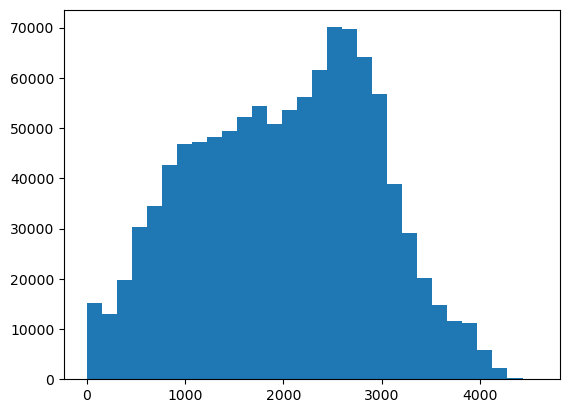

In [18]:
plt.hist(thickness, bins=30);

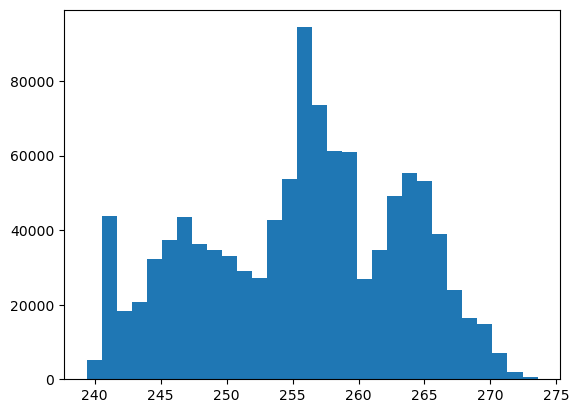

In [19]:
plt.hist(surf_temp, bins=30);

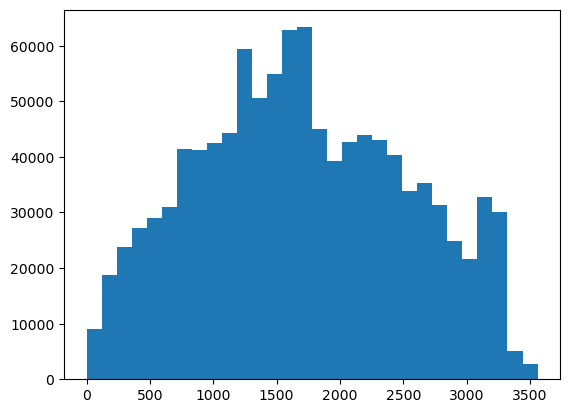

In [20]:
plt.hist(surf_elevation, bins=30);

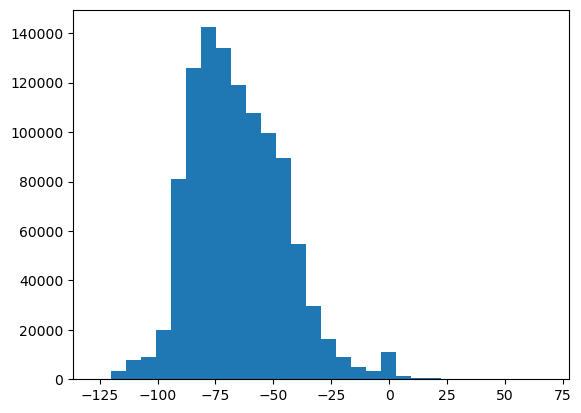

In [21]:
plt.hist(snr, bins=30);

All three of these have heavy tails, so we'll use robust scalar.

In [22]:
def combo_scaler(x, range_max=2):
    median_x = np.median(x)
    iqr_x = np.percentile(x,75) - np.percentile(x,25)
    robust_x = ((x-median_x)/iqr_x)

    return (((robust_x - np.nanmin(robust_x)) / (np.nanmax(robust_x) - np.nanmin(robust_x))) * range_max)-1

In [23]:
norm_thickness = combo_scaler(thickness)

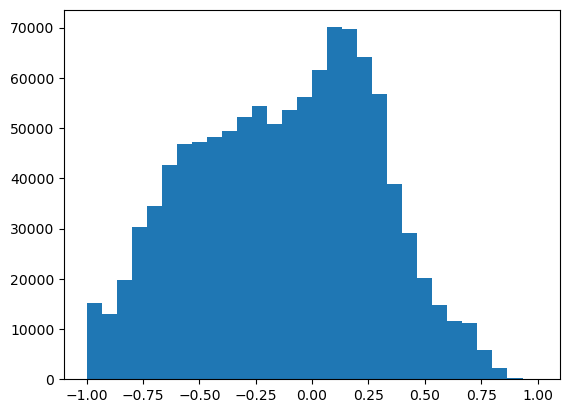

In [24]:
plt.hist(norm_thickness, bins=30);

In [25]:
norm_surf_temp = combo_scaler(surf_temp)

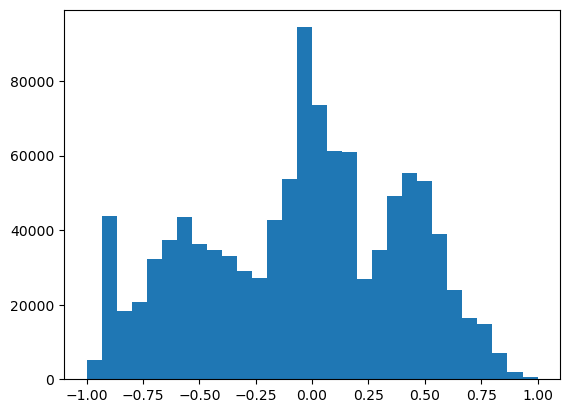

In [26]:
plt.hist(norm_surf_temp, bins=30);

In [27]:
norm_surf_elevation = combo_scaler(surf_elevation)

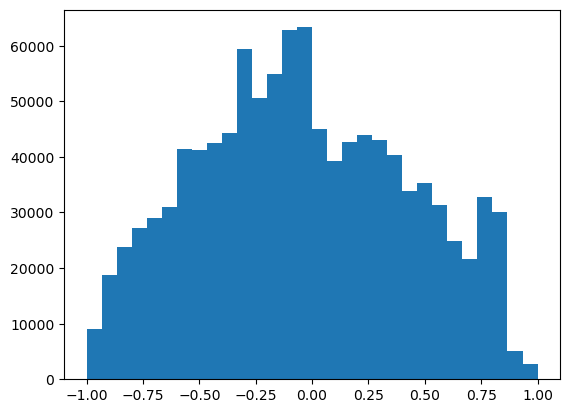

In [28]:
plt.hist(norm_surf_elevation, bins=30);

In [29]:
norm_snr = combo_scaler(snr)

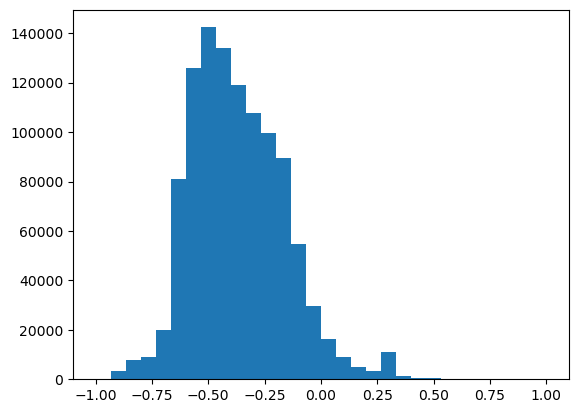

In [30]:
plt.hist(norm_snr, bins=30);

I've combo scaled them to preserve the underlying distribution of the data while keeping the distributions bounded around zero. NOTE! The distribution of snr clearly has a strong outlier, and might benefit from just robust scaling, and having it's long positive tail hang over 1. Can check how this affects outcomes.

### Run a Bayesian Linear Regression on the Texas Data

For now, I'm writing this without measurement uncertainty, but I will fold this in as soon as we have uncertainties. (Note to self: look back at my regression notebook for notes on how to do this properly.)

In [32]:
np.random.seed(42)

def ln_like(theta, thickness_obs, surf_temp_obs, surf_elev_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_temp, beta_surf_elev = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_temp*surf_temp_obs +
                            beta_surf_elev*surf_elev_obs
                           )
    
    # uncertainties = np.sqrt(xerr**2 + yerr**2)
    # ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))

    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [33]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
likelihood = minimize(nll, initial, 
                      args=(norm_thickness, norm_surf_temp, 
                            norm_surf_elevation, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_temp_ml, beta_surf_elev_ml = likelihood.x

In [31]:
with pm.Model() as texas_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    b3 = pm.Normal("beta_surface_elev", beta_surf_elev_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_thickness + b2*norm_surf_temp + b3*norm_surf_elevation

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    texas_trace = pm.sample(1000, cores=3,
                            target_accept=0.8, 
                            idata_kwargs={"log_likelihood": True})

NameError: name 'beta_0_ml' is not defined

Now that this has finished running, let's investigate convergence.

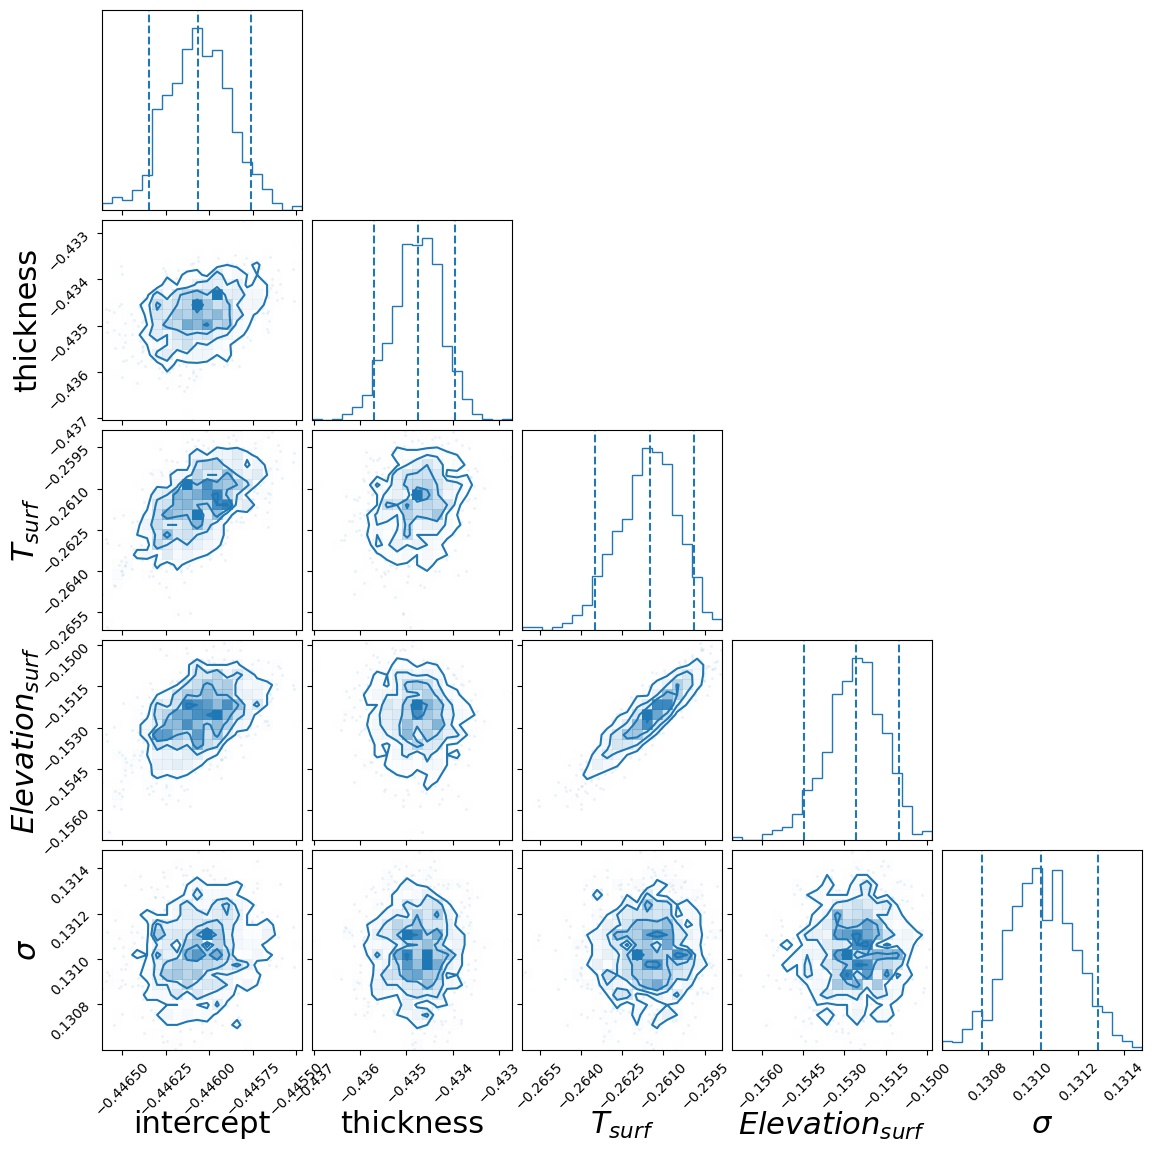

In [35]:
fig = corner.corner(np.vstack((texas_trace.posterior['intercept'][0],
                               texas_trace.posterior['beta_thickness'][0],
                               texas_trace.posterior['beta_surface_temp'][0],
                               texas_trace.posterior['beta_surface_elev'][0],
                               texas_trace.posterior['sigma'][0])).T, 
                    labels = ['intercept', 'thickness', 
                              '$T_{surf}$', '$Elevation_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

Let's look more closely at these coefficients:

In [36]:
az.summary(texas_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                          'beta_thickness', 
                                                          'beta_surface_temp', 
                                                          'beta_surface_elev',
                                                          'sigma'], :]

mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  \
intercept         -0.446  0.000   -0.446   -0.446        0.0      0.0   
beta_thickness    -0.435  0.001   -0.435   -0.434        0.0      0.0   
beta_surface_temp -0.262  0.001   -0.263   -0.261        0.0      0.0   
beta_surface_elev -0.153  0.001   -0.154   -0.152        0.0      0.0   
sigma              0.131  0.000    0.131    0.131        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
intercept          1974.660  1913.466  1.002  
beta_thickness     2288.410  2075.197  1.000  
beta_surface_temp  1722.883  1838.298  1.001  
beta_surface_elev  1725.913  1778.905  1.001  
sigma              2235.832  2014.764  1.001

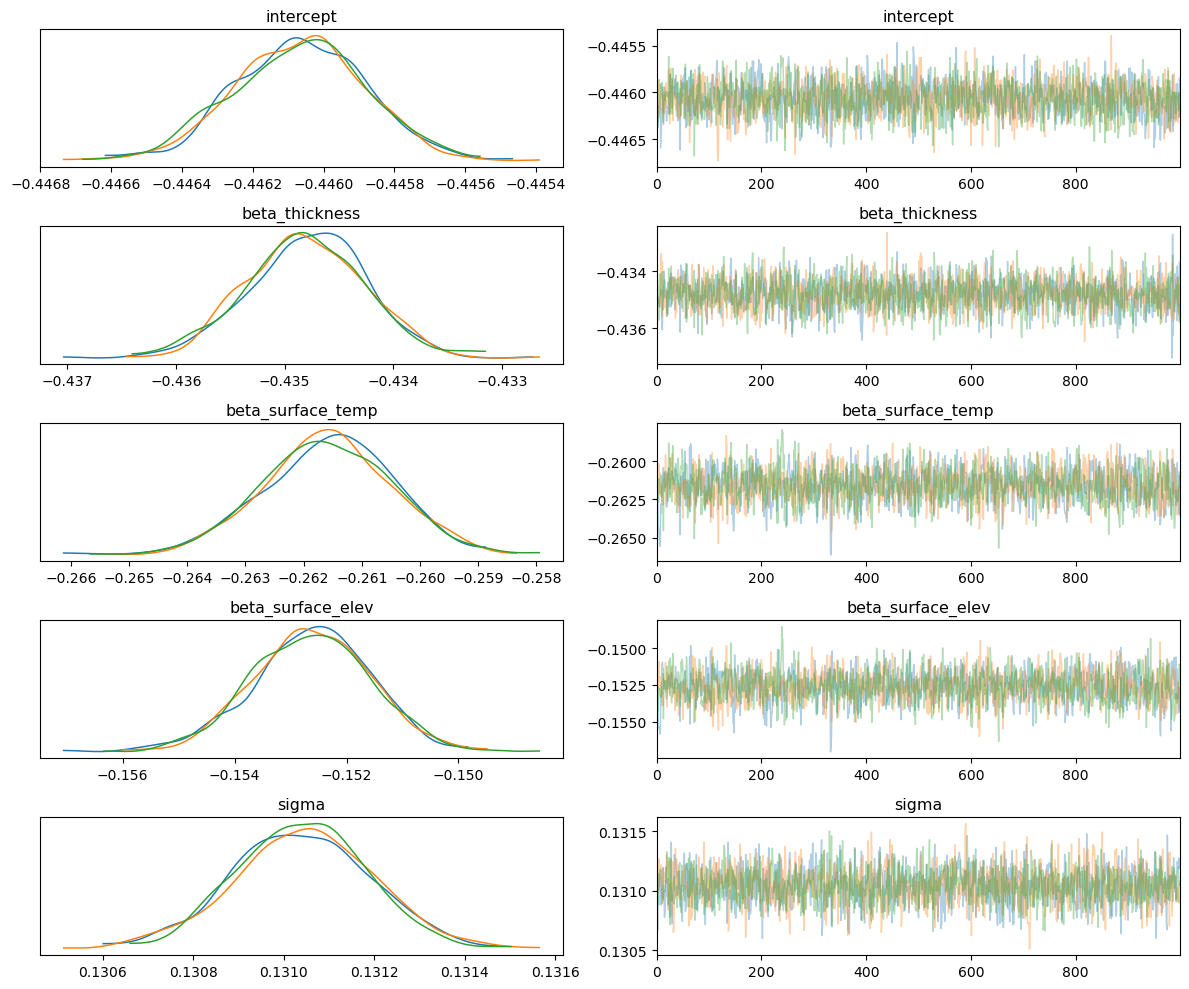

In [37]:
az.plot_trace(texas_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_temp', 'beta_surface_elev',
                         'sigma'], 
              combined=False, compact=False)

plt.tight_layout()

In [39]:
texas_trace.to_netcdf("texas_grounded_trace.nc")

'texas_grounded_trace.nc'

### Same analysis for floating ice

In [107]:
floating_df = variable_df.loc[variable_df['bm_mask']==3]

In [108]:
thickness = floating_df['thickness']
speed = floating_df['log_speed']
surf_elevation = floating_df['surface']
snr = floating_df['snr']

In [16]:
norm_thickness = combo_scaler(thickness)
norm_speed = combo_scaler(speed)
norm_surf_elevation = combo_scaler(surf_elevation)
norm_snr = combo_scaler(snr)

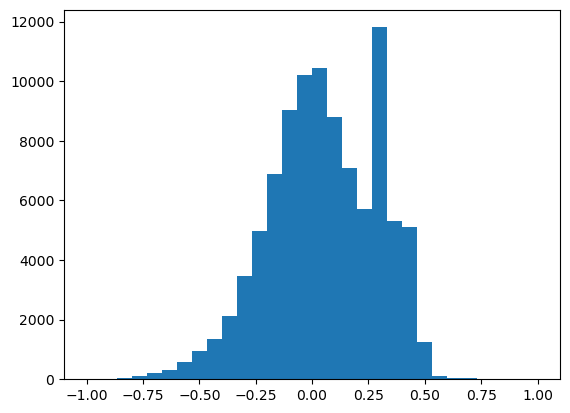

In [17]:
plt.hist(norm_snr, bins=30);

In [18]:
np.random.seed(42)

def ln_like(theta, thickness_obs, speed_obs, surf_elev_obs, snr_sim):
    beta_0, beta_thickness, beta_speed, beta_surf_elev = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_speed*speed_obs +
                            beta_surf_elev*surf_elev_obs
                           )
    
    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [19]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
likelihood = minimize(nll, initial, 
                      args=(norm_thickness, norm_speed, 
                            norm_surf_elevation, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_speed_ml, beta_surf_elev_ml = likelihood.x

In [20]:
with pm.Model() as floating_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_speed", beta_speed_ml, sigma=10)
    b3 = pm.Normal("beta_surface_elev", beta_surf_elev_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_thickness + b2*norm_speed + b3*norm_surf_elevation

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    floating_trace = pm.sample(1000, cores=3,
                           target_accept=0.8)#,
                           # return_inferencedata=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_speed, beta_surface_elev, nu]


Output()

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 722 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


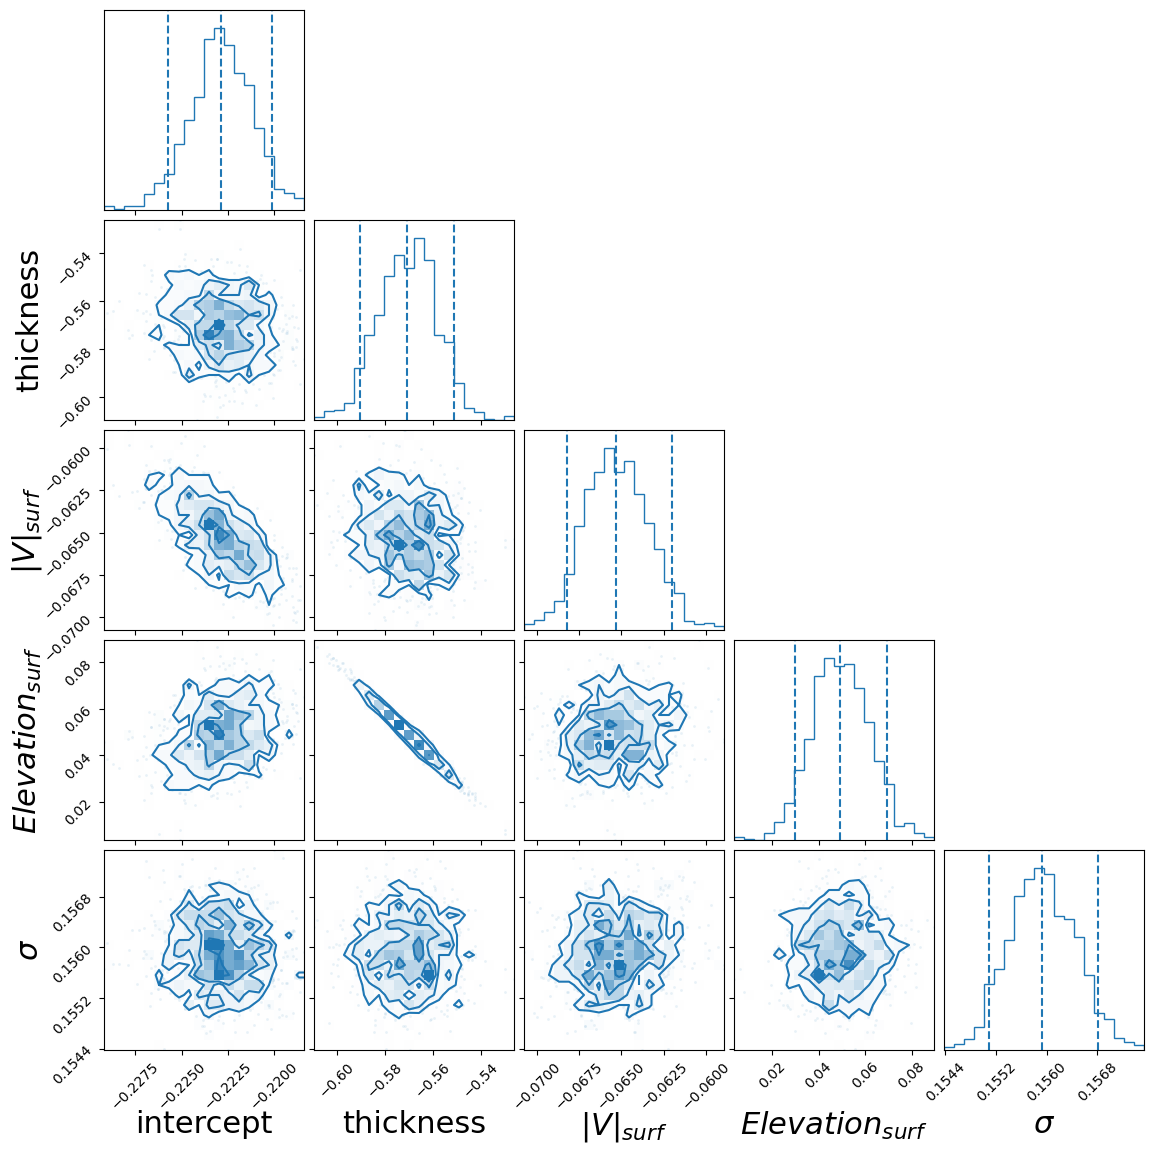

In [21]:
fig = corner.corner(np.vstack((floating_trace.posterior['intercept'][0],
                               floating_trace.posterior['beta_thickness'][0],
                               floating_trace.posterior['beta_speed'][0],
                               floating_trace.posterior['beta_surface_elev'][0],
                               floating_trace.posterior['sigma'][0])).T, 
                    labels = ['intercept', 'thickness', 
                              '$|V|_{surf}$', '$Elevation_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

In [22]:
az.summary(floating_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 'beta_thickness',
                                                             'beta_speed',
                                                             'beta_surface_elev', 'sigma'], :]

mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  \
intercept         -0.223  0.002   -0.225   -0.221        0.0      0.0   
beta_thickness    -0.571  0.013   -0.585   -0.559        0.0      0.0   
beta_speed        -0.065  0.002   -0.067   -0.063        0.0      0.0   
beta_surface_elev  0.050  0.013    0.038    0.064        0.0      0.0   
sigma              0.156  0.001    0.155    0.156        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
intercept          1710.400  1500.062  1.003  
beta_thickness     1233.335  1334.005  1.001  
beta_speed         1756.846  1770.530  1.001  
beta_surface_elev  1207.492  1281.327  1.001  
sigma              1180.913  1725.043  1.003

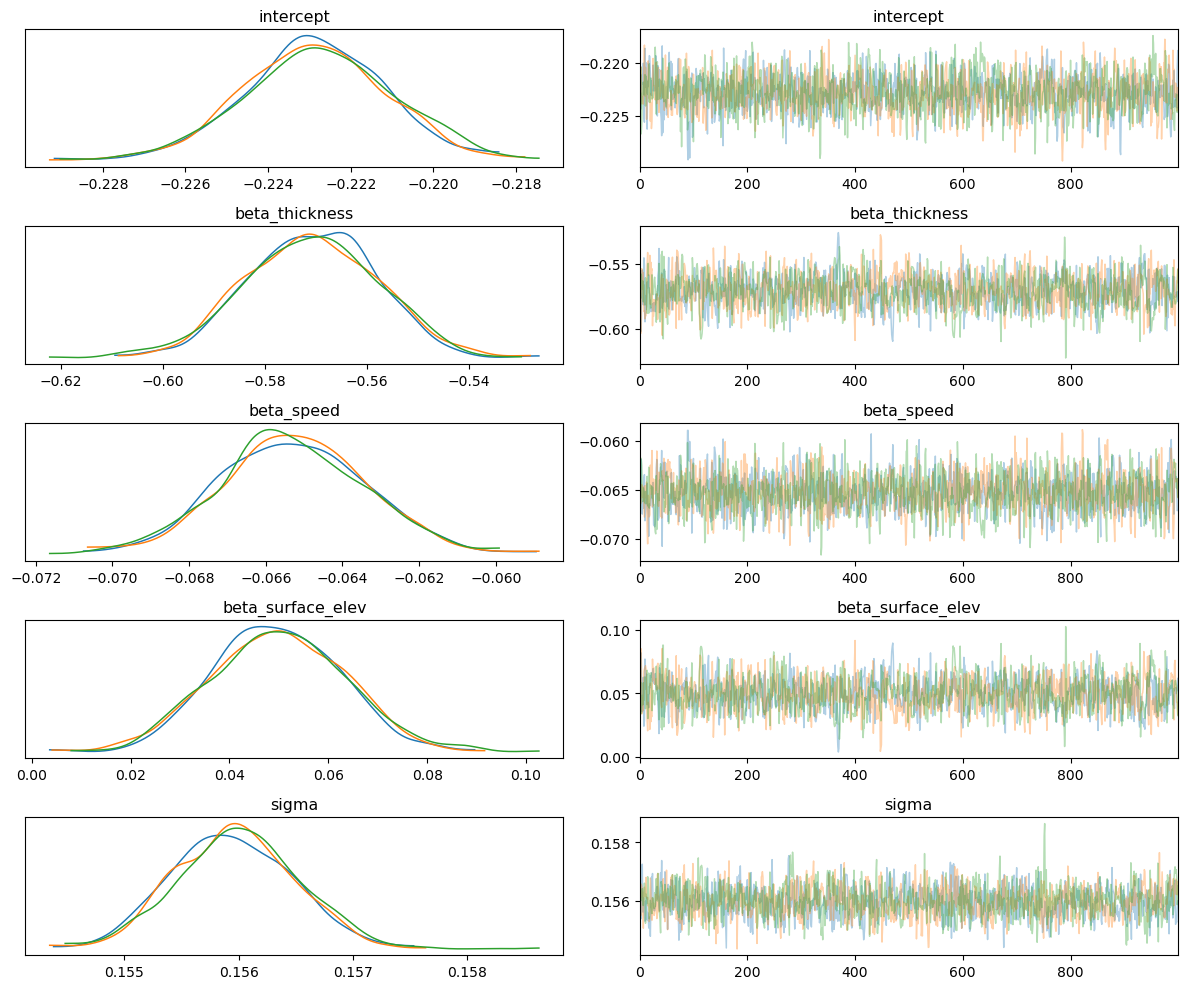

In [27]:
az.plot_trace(floating_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_speed',
                         'beta_surface_elev', 'sigma'], 
              combined=False, compact=False)

plt.tight_layout()

In [29]:
texas_floating_fit_df = az.summary(floating_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                                            'beta_thickness',
                                                                            'beta_speed',
                                                                            'beta_surface_elev', 
                                                                            'sigma'], :]

In [30]:
texas_floating_estimate = texas_floating_fit_df['mean']['intercept'] + \
                 texas_floating_fit_df['mean']['beta_thickness']*norm_thickness + \
                 texas_floating_fit_df['mean']['beta_speed']*norm_speed + \
                 texas_floating_fit_df['mean']['beta_surface_elev']*norm_surf_elevation

/tmp/ipykernel_110/3040279858.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


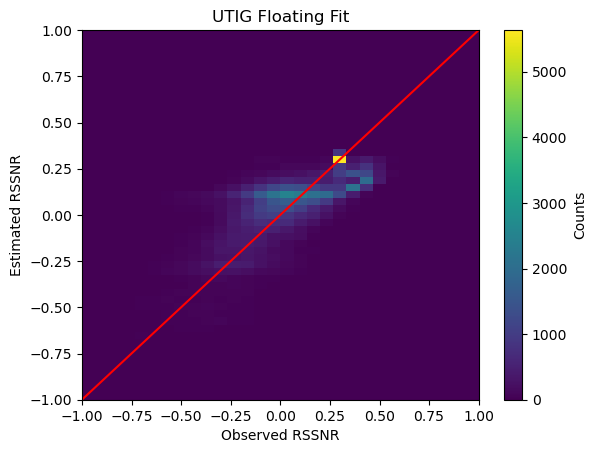

In [32]:
viridis = cm.get_cmap('viridis')
bg_color = viridis(0)  

fig, ax = plt.subplots()
ax.set_facecolor(bg_color)

h = ax.hist2d(norm_snr, texas_floating_estimate, 
              bins=30, cmap='viridis')

ax.plot([-1,1],[-1,1], c='red')

ax.set_ylim([-1,1])

# Add colorbar and labels
plt.colorbar(h[3], ax=ax, label='Counts')

plt.title('UTIG Floating Fit')
plt.ylabel('Estimated RSSNR')
plt.xlabel('Observed RSSNR');

In [24]:
floating_trace.to_netcdf("texas_floating_trace.nc")

'texas_floating_trace.nc'

Look at how this plots vs. observed.

## Model Exploration on the CRESIS Data

### Import CRESIS for Antarctica

In [14]:
data = xr.open_dataset('external_datasets/snr_data_cresis_ais_with_inputs.nc')

In [15]:
cresis_df = data.to_dataframe()

In [16]:
variable_df = cresis_df.loc[(~np.isnan(cresis_df['snr'])) & 
                            (~np.isnan(cresis_df['thickness'])) &
                            (~np.isnan(cresis_df['speed'])) &
                            (~np.isnan(cresis_df['t2m'])) &
                            (~np.isnan(cresis_df['surface'])) &
                            (~np.isnan(cresis_df['bm_mask']))
                           ]

In [17]:
variable_df['log_speed'] = np.log(variable_df['speed'])
variable_df = variable_df[~np.isinf(variable_df['log_speed'])]

/tmp/ipykernel_111/2873116753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variable_df['log_speed'] = np.log(variable_df['speed'])


In [18]:
grounded_df = variable_df.loc[variable_df['bm_mask']==2]

We won't do floating ice for CRESIS because there just isn't enough signal.

In [39]:
len(grounded_df)

1111481

### Norm the CRESIS variable columns for Grounded Ice

We'll do two different normalizations for grounded and floating ice, because we expect them to be from different underlying distributions.

In [40]:
thickness = grounded_df['thickness']
surf_temp = grounded_df['t2m']
surf_elevation = grounded_df['surface']
snr = grounded_df['snr']

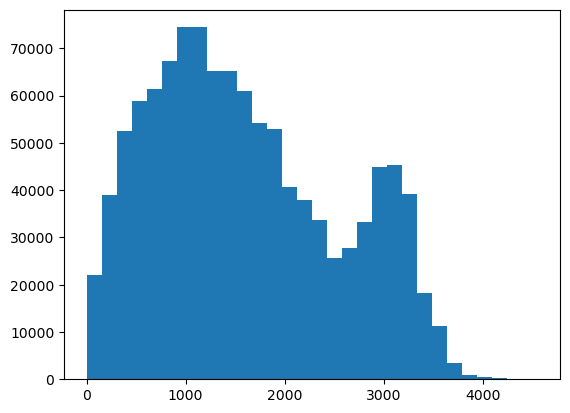

In [41]:
plt.hist(thickness, bins=30);

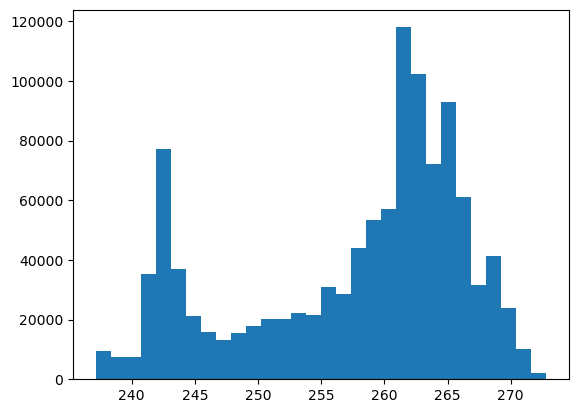

In [42]:
plt.hist(surf_temp, bins=30);

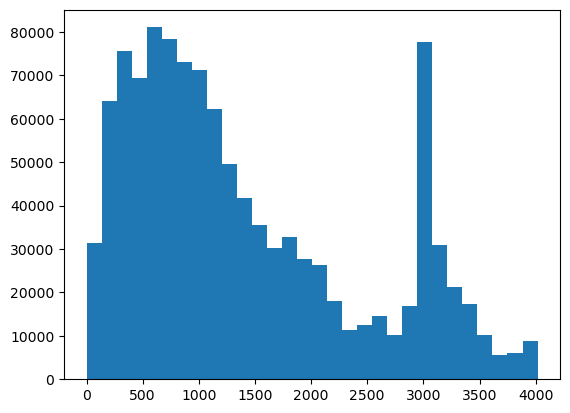

In [43]:
plt.hist(surf_elevation, bins=30);

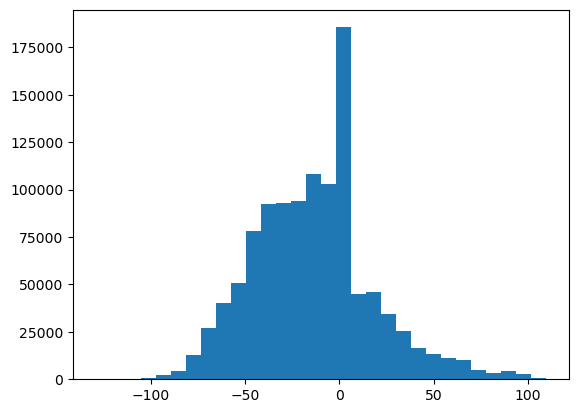

In [44]:
plt.hist(snr, bins=30);

In [45]:
norm_thickness = combo_scaler(thickness)

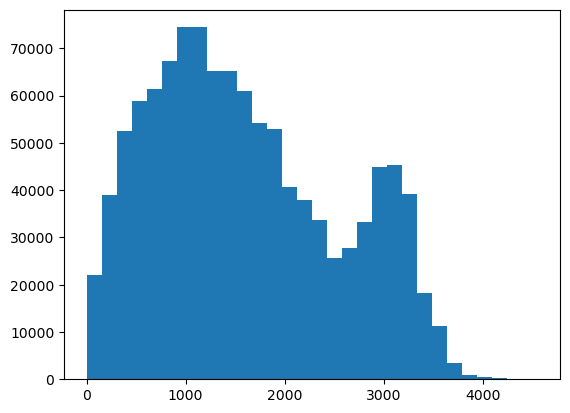

In [46]:
plt.hist(thickness, bins=30);

In [47]:
norm_surf_temp = combo_scaler(surf_temp)

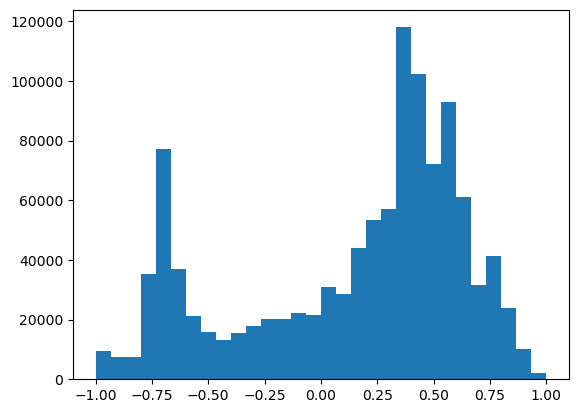

In [48]:
plt.hist(norm_surf_temp, bins=30);

In [49]:
norm_surf_elevation = combo_scaler(surf_elevation)

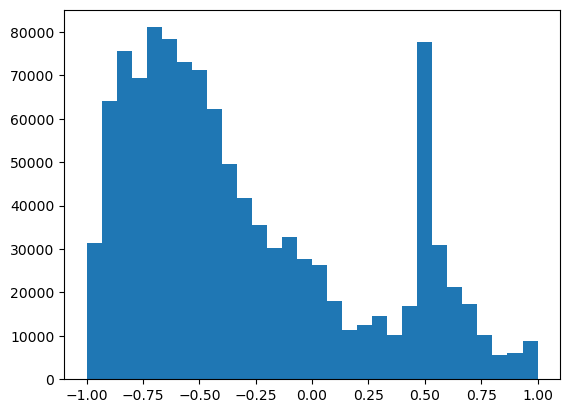

In [50]:
plt.hist(norm_surf_elevation, bins=30);

In [51]:
norm_snr = combo_scaler(snr)

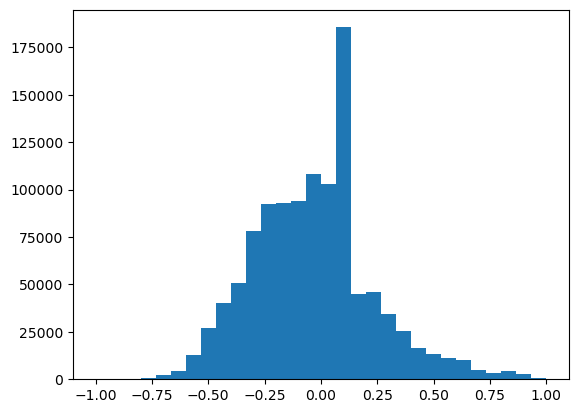

In [52]:
plt.hist(norm_snr, bins=30);

### Bayesian Linear Regression on Cresis Data

I'm assuming here that the data is student t distributed (see Texas section for more details). To fold uncertainties in, we need to propagate through the scaling for their mean value. I'll add that in after some initial model exploration.

In [61]:
np.random.seed(42)

def ln_like(theta, thickness_obs, surf_temp_obs, surf_elev_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_temp, beta_surf_elev = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_temp*surf_temp_obs +
                            beta_surf_elev*surf_elev_obs
                           )
    
    # uncertainties = np.sqrt(xerr**2 + yerr**2)
    # ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))

    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [62]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
likelihood = minimize(nll, initial, 
                      args=(norm_thickness, norm_surf_temp, 
                            norm_surf_elevation, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_temp_ml, beta_surf_elev_ml = likelihood.x

In [63]:
with pm.Model() as cresis_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    b3 = pm.Normal("beta_surface_elev", beta_surf_elev_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_thickness + b2*norm_surf_temp + b3*norm_surf_elevation

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    cresis_trace = pm.sample(1000, cores=3,
                             target_accept=0.8,
                             idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_surface_temp, beta_surface_elev, nu]


Output()

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 3742 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


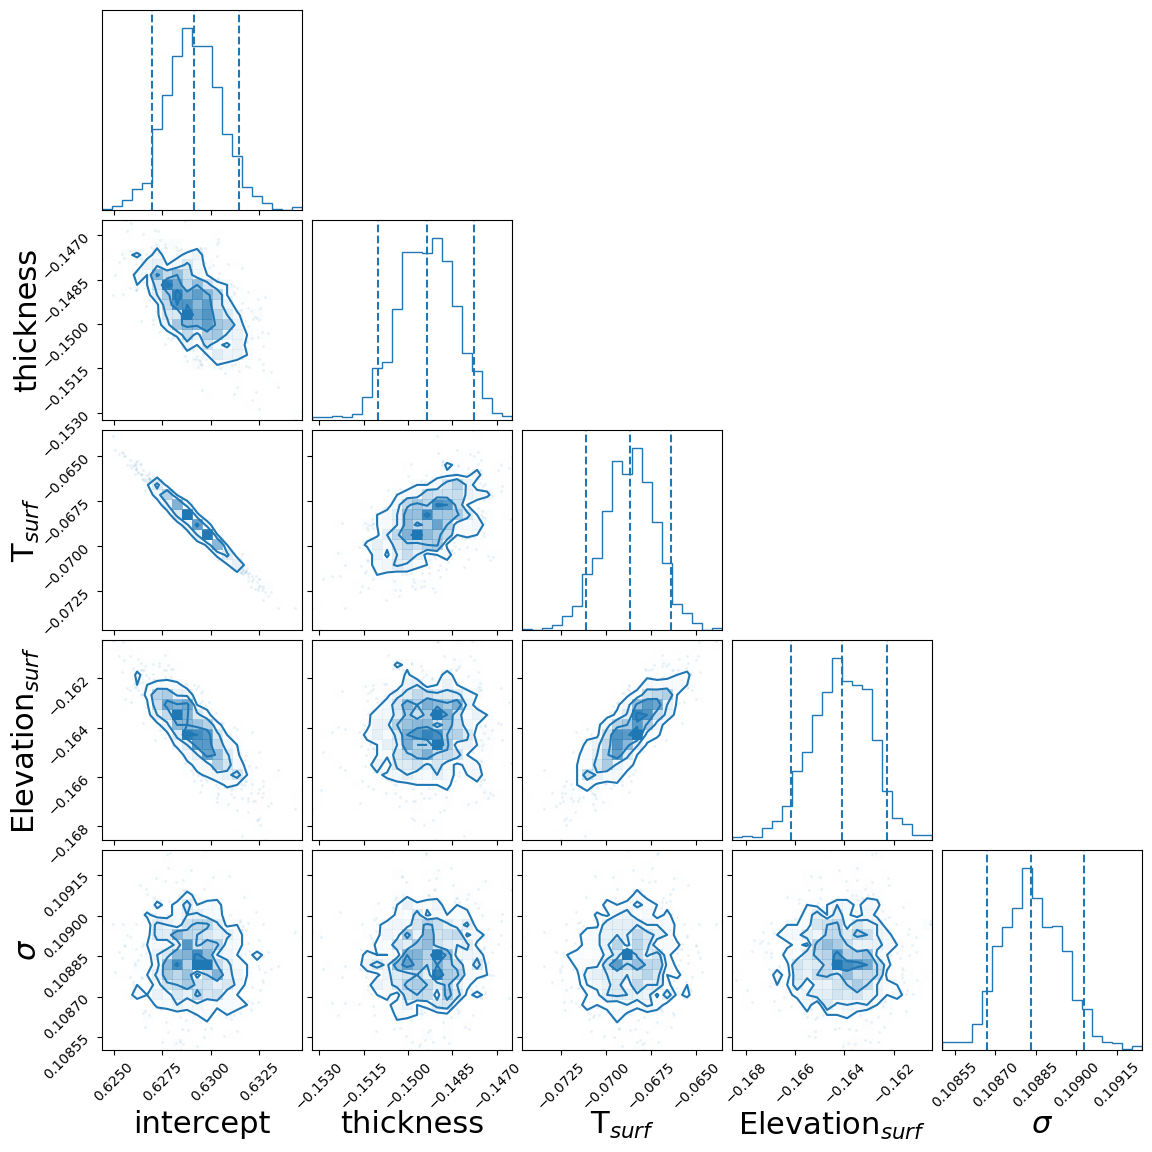

In [64]:
fig = corner.corner(np.vstack((cresis_trace.posterior['intercept'][0],
                               cresis_trace.posterior['beta_thickness'][0],
                               cresis_trace.posterior['beta_surface_temp'][0],
                               cresis_trace.posterior['beta_surface_elev'][0],
                               cresis_trace.posterior['sigma'][0])).T, 
                    labels = ['intercept', 'thickness', 
                              'T$_{surf}$', 'Elevation$_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

In [65]:
az.summary(cresis_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                            'beta_surface_elev', 
                                                            'sigma'], :]

mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  \
intercept          0.629  0.001    0.628    0.631        0.0      0.0   
beta_thickness    -0.149  0.001   -0.150   -0.148        0.0      0.0   
beta_surface_temp -0.069  0.002   -0.070   -0.067        0.0      0.0   
beta_surface_elev -0.164  0.001   -0.166   -0.163        0.0      0.0   
sigma              0.109  0.000    0.109    0.109        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
intercept           921.612  1343.441  1.004  
beta_thickness     1660.131  1620.415  1.001  
beta_surface_temp   969.626  1395.921  1.004  
beta_surface_elev  1138.614  1428.982  1.003  
sigma              1479.395  1714.667  1.000

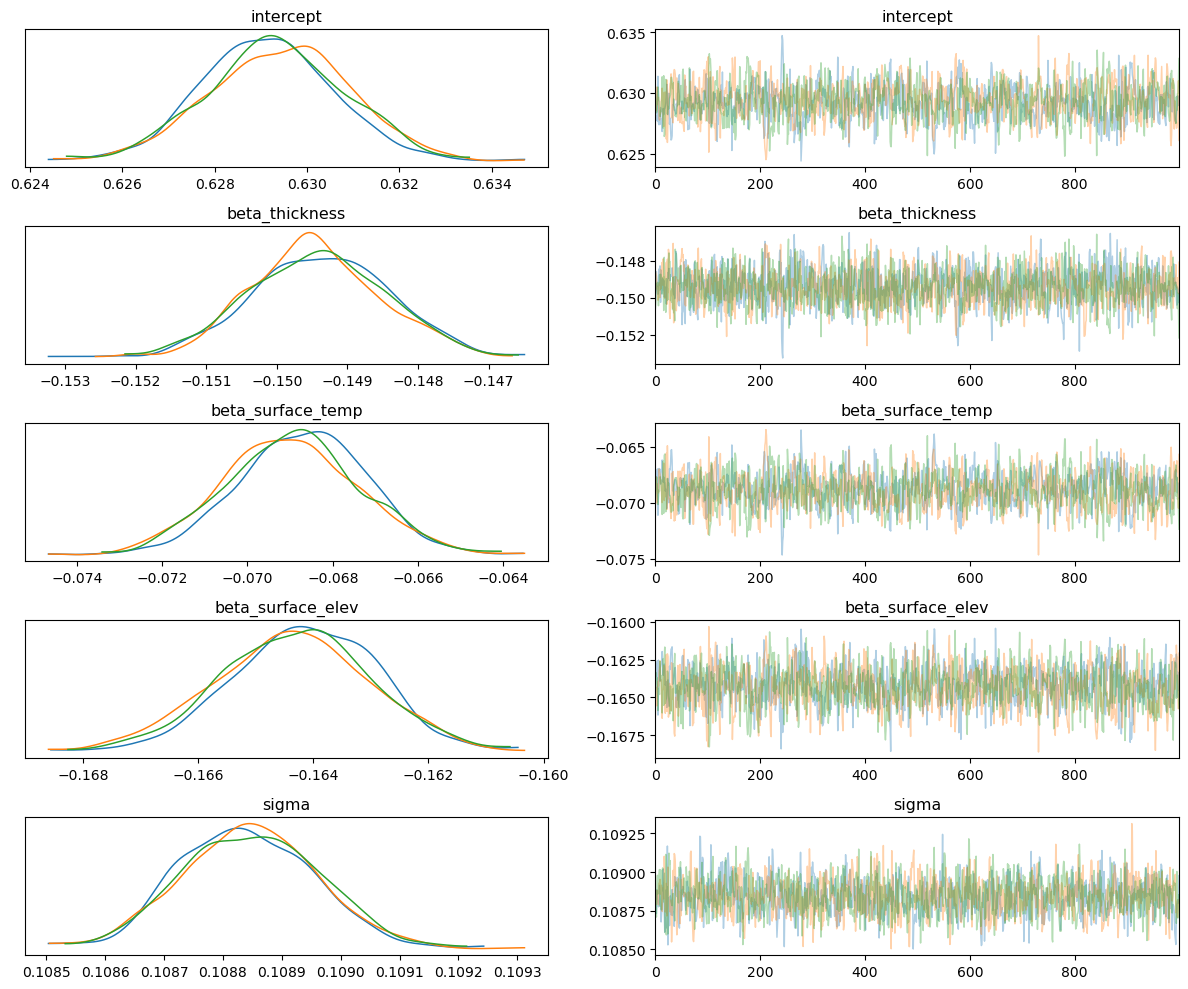

In [66]:
az.plot_trace(cresis_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_temp', 'beta_surface_elev', 
                         'sigma'], 
              combined=False, compact=False)
plt.tight_layout()

In [ ]:
cresis_trace.to_netcdf("cresis_grounded_updated_trace.nc")

### Running a CRESIS Alternative without Thickness

In the pairplots, CRESIS showed a lack of correlation with thickness. The following section explores how the fit performs without thickness.

In [43]:
np.random.seed(42)

def ln_like(theta, surf_temp_obs, surf_elev_obs, snr_sim):
    beta_0, beta_surf_temp, beta_surf_elev = theta
    model = beta_0 * np.exp(beta_surf_temp*surf_temp_obs +
                            beta_surf_elev*surf_elev_obs
                           )
    
    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [44]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,3) + 0.1 * np.random.randn(3)
likelihood = minimize(nll, initial, 
                      args=(norm_surf_temp, 
                            norm_surf_elevation, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_surf_temp_ml, beta_surf_elev_ml = likelihood.x

In [45]:
with pm.Model() as cresis_alt_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    b2 = pm.Normal("beta_surface_elev", beta_surf_elev_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_surf_temp + b2*norm_surf_elevation

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    cresis_alt_trace = pm.sample(1000, cores=3,
                             target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_surface_temp, beta_surface_elev, nu]


Output()

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 1768 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


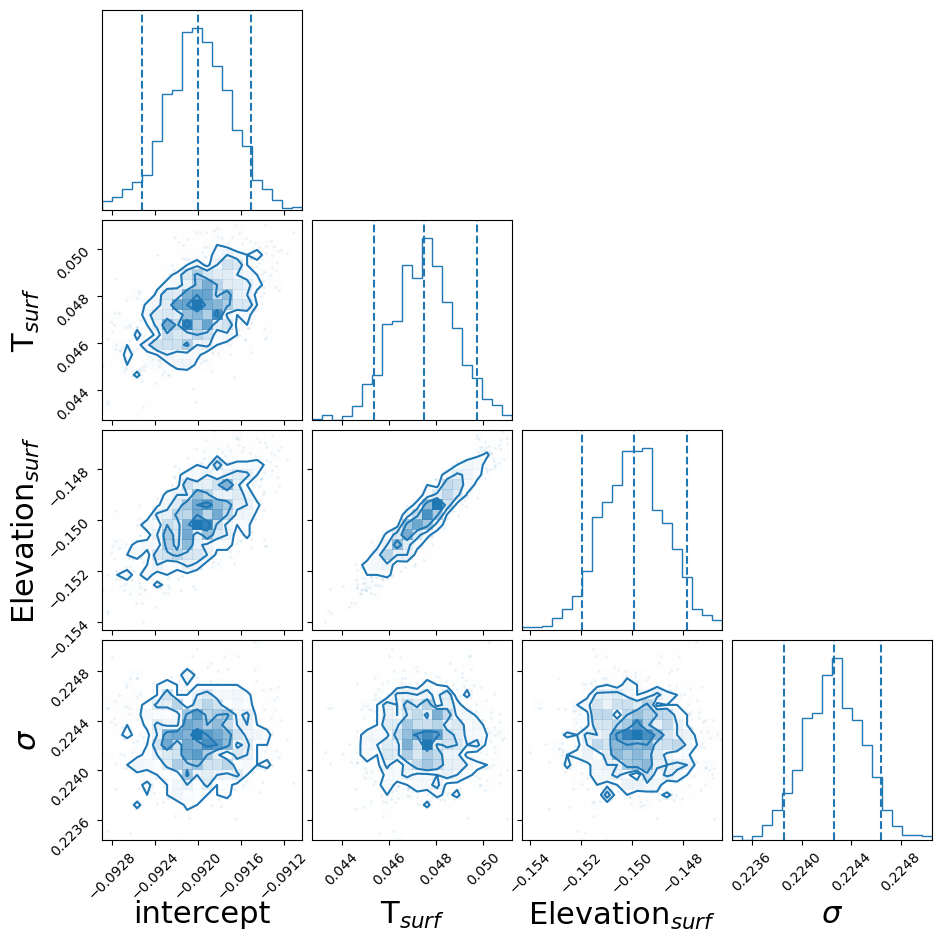

In [47]:
fig = corner.corner(np.vstack((cresis_alt_trace.posterior['intercept'][0],
                               cresis_alt_trace.posterior['beta_surface_temp'][0],
                               cresis_alt_trace.posterior['beta_surface_elev'][0],
                               cresis_alt_trace.posterior['sigma'][0])).T, 
                    labels = ['intercept',
                              'T$_{surf}$', 'Elevation$_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

In [48]:
az.summary(cresis_alt_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_surface_temp',
                                                           'beta_surface_elev', 
                                                           'sigma'], :]

mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  \
intercept         -0.092  0.000   -0.092   -0.092        0.0      0.0   
beta_surface_temp  0.047  0.001    0.046    0.049        0.0      0.0   
beta_surface_elev -0.150  0.001   -0.151   -0.149        0.0      0.0   
sigma              0.224  0.000    0.224    0.225        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
intercept          1492.762  1731.169  1.000  
beta_surface_temp  1423.745  1273.111  1.001  
beta_surface_elev  1362.115  1277.565  1.001  
sigma              1321.101  1496.261  1.002

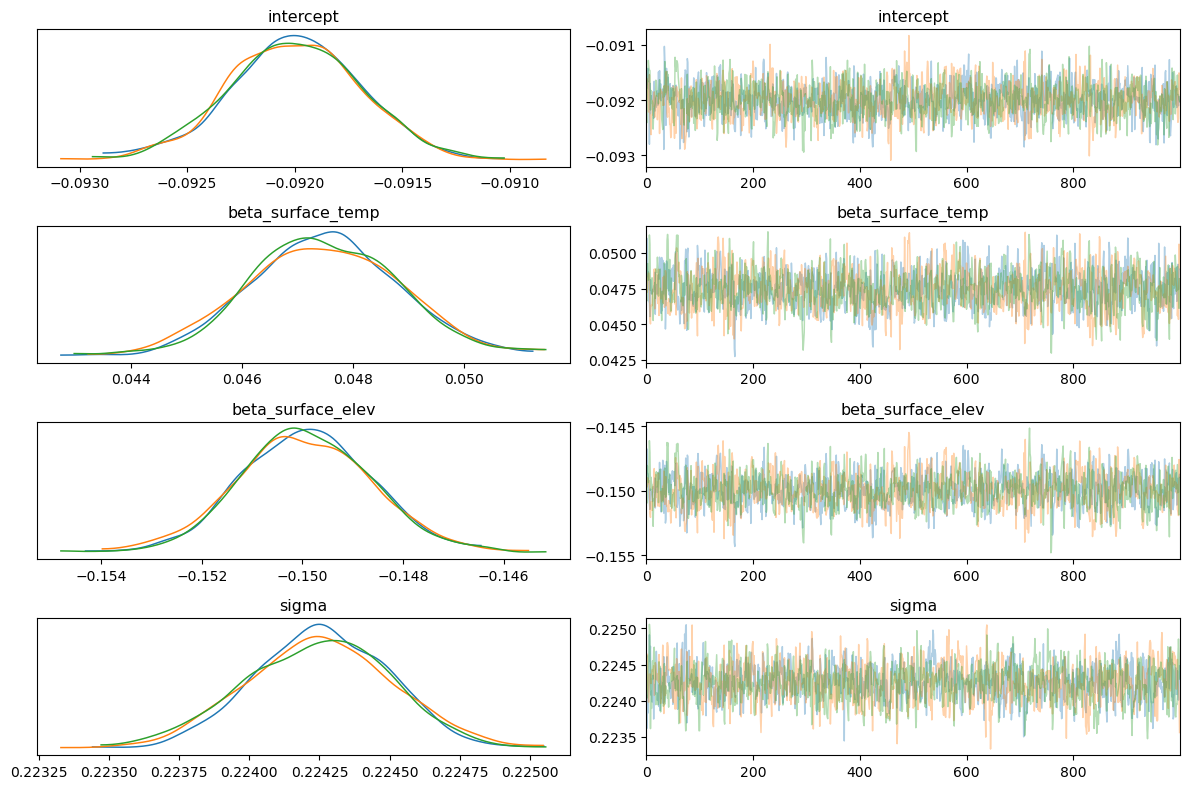

In [49]:
az.plot_trace(cresis_alt_trace, 
              var_names=['intercept', 
                         'beta_surface_temp', 
                         'beta_surface_elev', 
                         'sigma'], 
              combined=False, compact=False)
plt.tight_layout()

Let's contrast all of these fits:

In [22]:
cresis_full_fit_df = az.summary(cresis_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                           'beta_surface_elev', 
                                                           'sigma'], :]

In [23]:
# cresis_alt_fit_df = az.summary(cresis_alt_trace, hdi_prob = 0.68, round_to=3).loc[['intercept',  
#                                                            'beta_surface_temp',
#                                                            'beta_surface_elev', 
#                                                            'sigma'], :]

combo_fit_df = az.summary(combined_trace, hdi_prob = 0.68, round_to=3).loc[['intercept',
                                                           'beta_thickness',
                                                           'beta_surface_temp',
                                                           'beta_surface_elev', 
                                                           'sigma'], :]

In [24]:
texas_fit_df = az.summary(texas_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                           'beta_surface_elev', 
                                                           'sigma'], :]

In [25]:
texas_fit_df['mean']

intercept           -0.446
beta_thickness      -0.435
beta_surface_temp   -0.262
beta_surface_elev   -0.153
sigma                0.131
Name: mean, dtype: float64

In [26]:
cresis_full_fit_df['mean']

intercept           -0.124
beta_thickness      -0.149
beta_surface_temp   -0.069
beta_surface_elev   -0.164
sigma                0.218
Name: mean, dtype: float64

In [95]:
# new_row = pd.DataFrame([[np.nan]*cresis_alt_fit_df.shape[1]], 
#                        columns=cresis_alt_fit_df.columns, 
#                        index=['beta_thickness'])

In [96]:
# insert_at = cresis_alt_fit_df.index.get_loc('intercept') + 1

In [98]:
# cresis_alt_fit_df = pd.concat([cresis_alt_fit_df.iloc[:insert_at], 
#                                new_row, 
#                                cresis_alt_fit_df.iloc[insert_at:]])

In [27]:
combo_fit_df['mean']

intercept           -0.390
beta_thickness      -0.406
beta_surface_temp   -0.378
beta_surface_elev   -0.333
sigma                0.250
Name: mean, dtype: float64

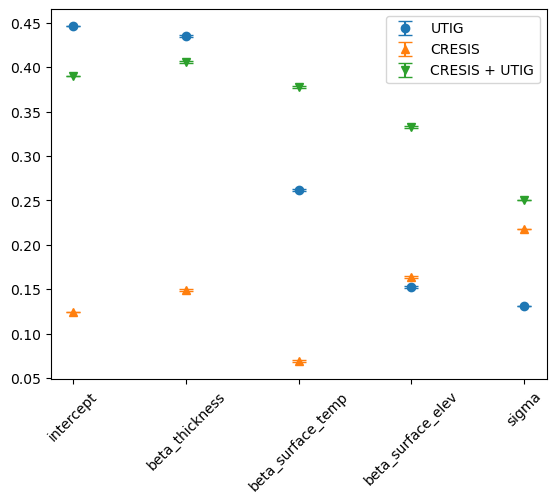

In [105]:
plt.figure()

plt.errorbar(texas_fit_df.index, np.abs(texas_fit_df['mean']), 
             yerr=texas_fit_df['sd'], 
             fmt='o', capsize=5,
             label='UTIG')

plt.errorbar(cresis_full_fit_df.index, 
             np.abs(cresis_full_fit_df['mean']), 
             yerr=cresis_full_fit_df['sd'], 
             fmt='^', capsize=5,
             label='CRESIS')

plt.errorbar(combo_fit_df.index, 
             np.abs(combo_fit_df['mean']), 
             yerr=combo_fit_df['sd'], 
             fmt='v', capsize=5,
             label='CRESIS + UTIG')

plt.legend()

x = range(len(texas_fit_df))
x_labels = texas_fit_df.index
plt.xticks(ticks=x, labels=x_labels, rotation=45);

### How does the fit perform when the datasets are combined?

In [19]:
#cresis variables
thickness_cresis = grounded_df['thickness']
surf_temp_cresis = grounded_df['t2m']
surf_elevation_cresis = grounded_df['surface']
snr_cresis = grounded_df['snr']

#utig variables
thickness_utig = grounded_texas_df['thickness']
surf_temp_utig = grounded_texas_df['t2m']
surf_elevation_utig = grounded_texas_df['surface']
snr_utig = grounded_texas_df['snr']

In [20]:
combo_thickness = pd.concat([thickness_utig, thickness_cresis])
combo_surf_temp = pd.concat([surf_temp_utig, surf_temp_cresis])
combo_surf_elevation = pd.concat([surf_elevation_utig, surf_elevation_cresis])
combo_snr = pd.concat([snr_utig, snr_cresis])

In [37]:
norm_thickness = combo_scaler(thickness)
norm_surf_temp = combo_scaler(surf_temp)
norm_surf_elevation = combo_scaler(surf_elevation)
norm_snr = combo_scaler(snr)

In [22]:
np.random.seed(42)

def ln_like(theta, thickness_obs, surf_temp_obs, surf_elev_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_temp, beta_surf_elev = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_temp*surf_temp_obs +
                            beta_surf_elev*surf_elev_obs
                           )
    
    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [23]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
likelihood = minimize(nll, initial, 
                      args=(norm_thickness, norm_surf_temp, 
                            norm_surf_elevation, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_temp_ml, beta_surf_elev_ml = likelihood.x

In [ ]:
with pm.Model() as combined_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    b3 = pm.Normal("beta_surface_elev", beta_surf_elev_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_thickness + b2*norm_surf_temp + b3*norm_surf_elevation

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    combined_trace = pm.sample(1000, cores=3,
                               target_accept=0.8,
                               # idata_kwargs={"log_likelihood": True}
                              )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_surface_temp, beta_surface_elev, nu]


Output()

In [ ]:
fig = corner.corner(np.vstack((combined_trace.posterior['intercept'][0],
                               combined_trace.posterior['beta_thickness'][0],
                               combined_trace.posterior['beta_surface_temp'][0],
                               combined_trace.posterior['beta_surface_elev'][0],
                               combined_trace.posterior['sigma'][0])).T, 
                    labels = ['intercept', 'thickness', 
                              'T$_{surf}$', 'Elevation$_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

In [ ]:
az.summary(combined_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                            'beta_surface_elev', 
                                                            'sigma'], :]

In [ ]:
az.plot_trace(combined_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_temp', 'beta_surface_elev', 
                         'sigma'], 
              combined=False, compact=False)
plt.tight_layout()

In [ ]:
combined_trace.to_netcdf("combined_ais_trace.nc")

### LOO Analysis and Model Comparison

In [7]:
texas_trace = az.from_netcdf("texas_grounded_trace.nc")
cresis_trace = az.from_netcdf("cresis_grounded_trace.nc")

In [5]:
combined_trace = az.from_netcdf("combined_ais_trace.nc")

In [33]:
texas_loo = az.loo(texas_trace, pointwise=True)

In [43]:
with open("loo_utig.pkl", "wb") as f:
    pickle.dump(texas_loo, f)

In [8]:
# with open("loo_utig.pkl", "rb") as f:
#     utig_loo = pickle.load(f)

In [35]:
# cresis_loo = az.loo(cresis_trace, pointwise=True)
cresis_loo = az.loo(cresis_trace)

In [47]:
with open("loo_cresis.pkl", "wb") as f:
    pickle.dump(cresis_loo, f)

In [9]:
# with open("loo_cresis.pkl", "rb") as f:
#     cresis_loo = pickle.load(f)

In [1]:
import timeit
import dask
from arviz.utils import conditional_jit, Dask

In [6]:
# optional imports
from dask.distributed import Client
from dask.diagnostics import ResourceProfiler

In [7]:
client = Client(threads_per_worker=4, n_workers=1, memory_limit="25GB")
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37475 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:40917' processes=1 threads=4, memory=23.28 GiB>

In [8]:
combined_trace_dask = az.from_pymc(combined_trace, dask=True)

AttributeError: module 'arviz' has no attribute 'from_pymc'

In [ ]:
combined_loo = az.loo(combined_trace)

In [36]:
texas_loo

Computed from 3000 posterior samples and 1071291 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 511903.59   881.83
p_loo        6.83        -
------

Pareto k diagnostic values:
                           Count   Pct.
(-Inf, 0.70]   (good)     1071291  100.0%
   (0.70, 1]   (bad)            0    0.0%
   (1, Inf)   (very bad)       0    0.0%

In [37]:
cresis_loo

Computed from 3000 posterior samples and 1111481 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  4292.32   857.36
p_loo        5.87        -
------

Pareto k diagnostic values:
                           Count   Pct.
(-Inf, 0.70]   (good)     1111481  100.0%
   (0.70, 1]   (bad)            0    0.0%
   (1, Inf)   (very bad)       0    0.0%

In [11]:
comparison = az.compare({"UTIG": utig_loo, "CRESIS": cresis_loo}, method="BB-pseudo-BMA")
print(comparison)

ValueError: The number of observations should be the same across all models

In [ ]:
az.plot_compare(comparison)

In [ ]:
combined_loo = az.loo(combined_trace)

In [1]:
print('hello')

hello


### How does CRESIS perform when predicted using TX coefficients vs. its own coefficients vs. combined coefficients?

Taking a break from looking at the LOO on these. Let's see how these all perform, when predicting RSSNR of both.

In [21]:
texas_trace = az.from_netcdf("saved_traces/texas_grounded_trace.nc")
cresis_trace = az.from_netcdf("saved_traces/cresis_grounded_trace.nc")
combined_trace = az.from_netcdf("saved_traces/combined_ais_trace.nc")

In [39]:
cresis_full_fit_df = az.summary(cresis_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                           'beta_surface_elev', 
                                                           'sigma'], :]
combo_fit_df = az.summary(combined_trace, hdi_prob = 0.68, round_to=3).loc[['intercept',
                                                           'beta_thickness',
                                                           'beta_surface_temp',
                                                           'beta_surface_elev', 
                                                           'sigma'], :]
texas_fit_df = az.summary(texas_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                           'beta_surface_elev', 
                                                           'sigma'], :]

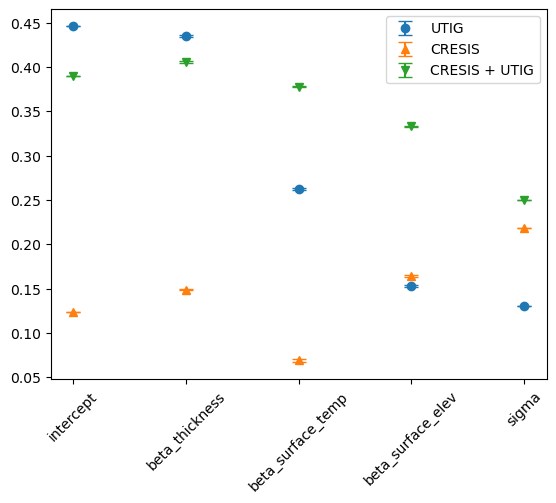

In [40]:
plt.figure()

plt.errorbar(texas_fit_df.index, np.abs(texas_fit_df['mean']), 
             yerr=texas_fit_df['sd'], 
             fmt='o', capsize=5,
             label='UTIG')

plt.errorbar(cresis_full_fit_df.index, 
             np.abs(cresis_full_fit_df['mean']), 
             yerr=cresis_full_fit_df['sd'], 
             fmt='^', capsize=5,
             label='CRESIS')

plt.errorbar(combo_fit_df.index, 
             np.abs(combo_fit_df['mean']), 
             yerr=combo_fit_df['sd'], 
             fmt='v', capsize=5,
             label='CRESIS + UTIG')

plt.legend()

x = range(len(texas_fit_df))
x_labels = texas_fit_df.index
plt.xticks(ticks=x, labels=x_labels, rotation=45);

In [41]:
texas_estimate = texas_fit_df['mean']['intercept'] + \
                 texas_fit_df['mean']['beta_thickness']*norm_thickness + \
                 texas_fit_df['mean']['beta_surface_temp']*norm_surf_temp + \
                 texas_fit_df['mean']['beta_surface_elev']*norm_surf_elevation

In [42]:
cresis_estimate = cresis_full_fit_df['mean']['intercept'] + \
                  cresis_full_fit_df['mean']['beta_thickness']*norm_thickness + \
                  cresis_full_fit_df['mean']['beta_surface_temp']*norm_surf_temp + \
                  cresis_full_fit_df['mean']['beta_surface_elev']*norm_surf_elevation

In [43]:
combo_estimate = combo_fit_df['mean']['intercept'] + \
                 combo_fit_df['mean']['beta_thickness']*norm_thickness + \
                 combo_fit_df['mean']['beta_surface_temp']*norm_surf_temp + \
                 combo_fit_df['mean']['beta_surface_elev']*norm_surf_elevation

/srv/conda/envs/notebook/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


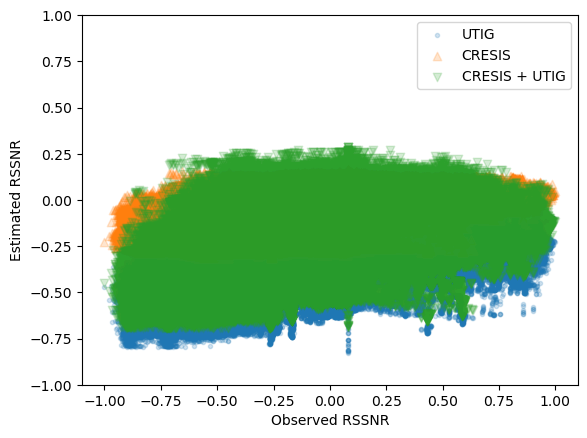

In [45]:
plt.figure()
plt.scatter(norm_snr, texas_estimate,
            alpha=0.2,
            marker='.', label='UTIG')
plt.scatter(norm_snr, cresis_estimate,
            alpha=0.2,
            marker='^', label='CRESIS')
plt.scatter(norm_snr, combo_estimate, 
            alpha=0.2,
            marker='v', label='CRESIS + UTIG')

plt.ylim([-1,1])

plt.legend()

plt.ylabel('Estimated RSSNR')
plt.xlabel('Observed RSSNR');

/tmp/ipykernel_132/1719471409.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


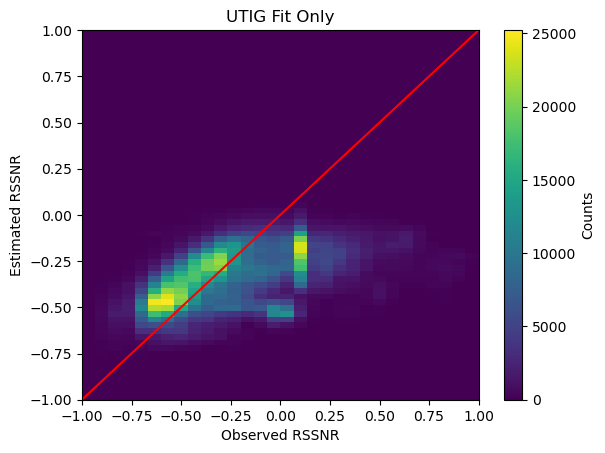

In [46]:
viridis = cm.get_cmap('viridis')
bg_color = viridis(0)  

fig, ax = plt.subplots()
ax.set_facecolor(bg_color)

h = ax.hist2d(norm_snr, texas_estimate, 
              bins=30, cmap='viridis')

ax.plot([-1,1],[-1,1], c='red')

ax.set_ylim([-1,1])

# Add colorbar and labels
plt.colorbar(h[3], ax=ax, label='Counts')

plt.title('UTIG Fit Only')
plt.ylabel('Estimated RSSNR')
plt.xlabel('Observed RSSNR');

/tmp/ipykernel_132/411189128.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


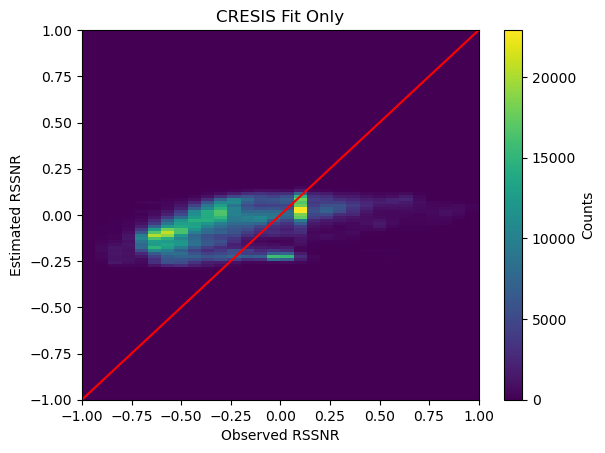

In [47]:
viridis = cm.get_cmap('viridis')
bg_color = viridis(0)  

fig, ax = plt.subplots()
ax.set_facecolor(bg_color)

h = ax.hist2d(norm_snr, cresis_estimate, 
              bins=30, cmap='viridis')

ax.plot([-1,1],[-1,1], c='red')

ax.set_ylim([-1,1])

# Add colorbar and labels
plt.colorbar(h[3], ax=ax, label='Counts')

plt.title('CRESIS Fit Only')
plt.ylabel('Estimated RSSNR')
plt.xlabel('Observed RSSNR');

/tmp/ipykernel_132/3417904241.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


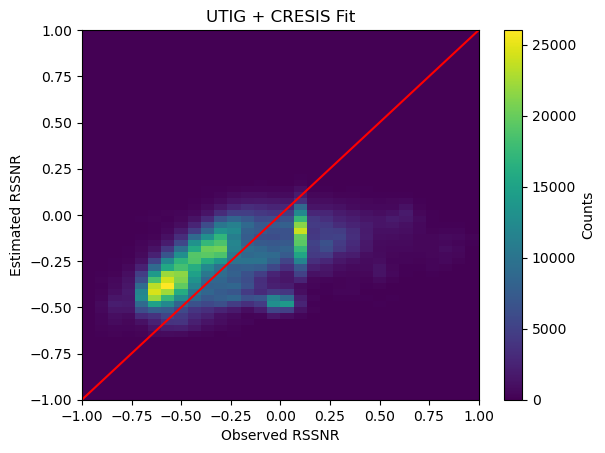

In [48]:
viridis = cm.get_cmap('viridis')
bg_color = viridis(0)  

fig, ax = plt.subplots()
ax.set_facecolor(bg_color)

h = ax.hist2d(norm_snr, combo_estimate, 
              bins=30, cmap='viridis')

ax.plot([-1,1],[-1,1], c='red')

ax.set_ylim([-1,1])

# Add colorbar and labels
plt.colorbar(h[3], ax=ax, label='Counts')

plt.title('UTIG + CRESIS Fit')
plt.ylabel('Estimated RSSNR')
plt.xlabel('Observed RSSNR');

## Model Fit on the Grounded GIS Using CRESIS

We're not going to fit the floating ice in the GIS using CRESIS because there isn't enough data points to provide a meaningful fit, but below we'll test the comparison between the GIS fit and the AIS fit to investigate the distribution shift between the two and see if it's reasonable to use CRESIS floating GIS data as a "test set" for our floating AIS fit from UTIG.

In [149]:
data = xr.open_dataset('external_datasets/snr_data_cresis_gis_with_inputs.nc')

In [150]:
cresis_df = data.to_dataframe()
variable_df = cresis_df.loc[(~np.isnan(cresis_df['snr'])) & 
                            (~np.isnan(cresis_df['thickness'])) &
                            (~np.isnan(cresis_df['speed'])) &
                            (~np.isnan(cresis_df['t2m'])) &
                            (~np.isnan(cresis_df['surface'])) &
                            (~np.isnan(cresis_df['bm_mask']))
                           ]

variable_df['log_speed'] = np.log(variable_df['speed'])
variable_df = variable_df[~np.isinf(variable_df['log_speed'])]

grounded_df = variable_df.loc[variable_df['bm_mask']==2]

/tmp/ipykernel_111/2572624800.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variable_df['log_speed'] = np.log(variable_df['speed'])


In [151]:
len(grounded_df)

1934893

### Normalize the Data

In [152]:
thickness = grounded_df['thickness']
surf_temp = grounded_df['t2m']
surf_elevation = grounded_df['surface']
snr = grounded_df['snr']

In [153]:
gis_thickness = grounded_df['thickness']
gis_surf_temp = grounded_df['t2m']
gis_surf_elevation = grounded_df['surface']
gis_snr = grounded_df['snr']

In [45]:
norm_thickness = combo_scaler(thickness)
norm_surf_temp = combo_scaler(surf_temp)
norm_surf_elevation = combo_scaler(surf_elevation)
norm_snr = combo_scaler(snr)

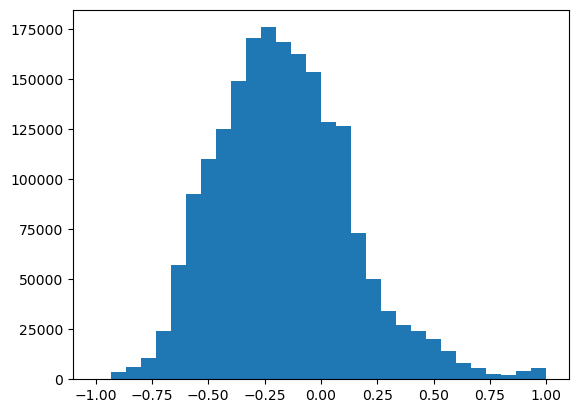

In [46]:
plt.hist(norm_snr, bins=30);

### Run the Fit

In [38]:
np.random.seed(42)

def ln_like(theta, thickness_obs, surf_temp_obs, surf_elev_obs, snr_sim):
    beta_0, beta_thickness, beta_surf_temp, beta_surf_elev = theta
    model = beta_0 * np.exp(beta_thickness*thickness_obs +
                            beta_surf_temp*surf_temp_obs +
                            beta_surf_elev*surf_elev_obs
                           )
    
    ln_z = -0.5 * np.sum((snr_sim - model)**2 + np.log(2*np.pi))
    
    return ln_z

In [39]:
nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
likelihood = minimize(nll, initial, 
                      args=(norm_thickness, norm_surf_temp, 
                            norm_surf_elevation, norm_snr), 
                      method='BFGS')
beta_0_ml, beta_thickness_ml, beta_surf_temp_ml, beta_surf_elev_ml = likelihood.x

In [40]:
with pm.Model() as gis_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", 1) #recommended for StudentT
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    b1 = pm.Normal("beta_thickness", beta_thickness_ml, sigma=10)
    b2 = pm.Normal("beta_surface_temp", beta_surf_temp_ml, sigma=10)
    b3 = pm.Normal("beta_surface_elev", beta_surf_elev_ml, sigma=10)
    # b_EX = pm.Normal("name", 0, sigma=0.1) #heavily regularizing prior, might be useful for colinear situations ahead
    

    # Define linear model
    y_est = b0 + b1*norm_thickness + b2*norm_surf_temp + b3*norm_surf_elevation

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood, because of the presence of outliers
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=norm_snr
    )
    
    gis_trace = pm.sample(1000, cores=3,
                          target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, intercept, beta_thickness, beta_surface_temp, beta_surface_elev, nu]


Output()

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 3926 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


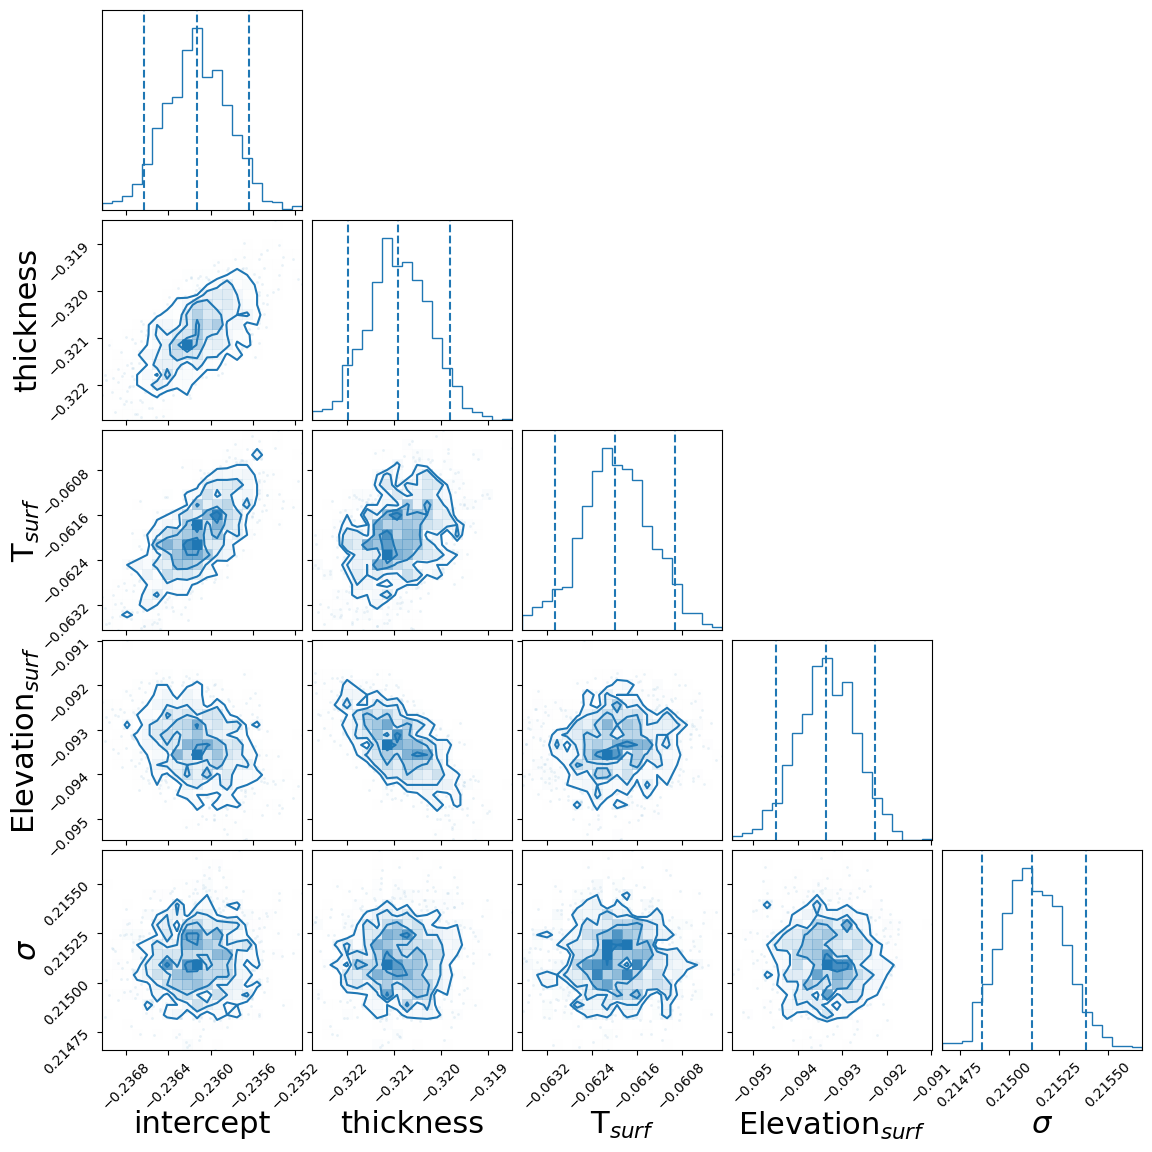

In [41]:
fig = corner.corner(np.vstack((gis_trace.posterior['intercept'][0],
                               gis_trace.posterior['beta_thickness'][0],
                               gis_trace.posterior['beta_surface_temp'][0],
                               gis_trace.posterior['beta_surface_elev'][0],
                               gis_trace.posterior['sigma'][0])).T, 
                    labels = ['intercept', 'thickness', 
                              'T$_{surf}$', 'Elevation$_{surf}$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, 
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

In [42]:
az.summary(gis_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                            'beta_surface_elev', 
                                                            'sigma'], :]

mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  \
intercept         -0.236  0.000   -0.236   -0.236        0.0      0.0   
beta_thickness    -0.321  0.001   -0.321   -0.320        0.0      0.0   
beta_surface_temp -0.062  0.001   -0.063   -0.061        0.0      0.0   
beta_surface_elev -0.093  0.001   -0.094   -0.093        0.0      0.0   
sigma              0.215  0.000    0.215    0.215        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
intercept          1645.904  1669.177  1.000  
beta_thickness     1795.318  1680.734  1.000  
beta_surface_temp  2057.770  1802.397  1.000  
beta_surface_elev  2445.622  1975.471  1.000  
sigma              1863.204  1888.161  1.002

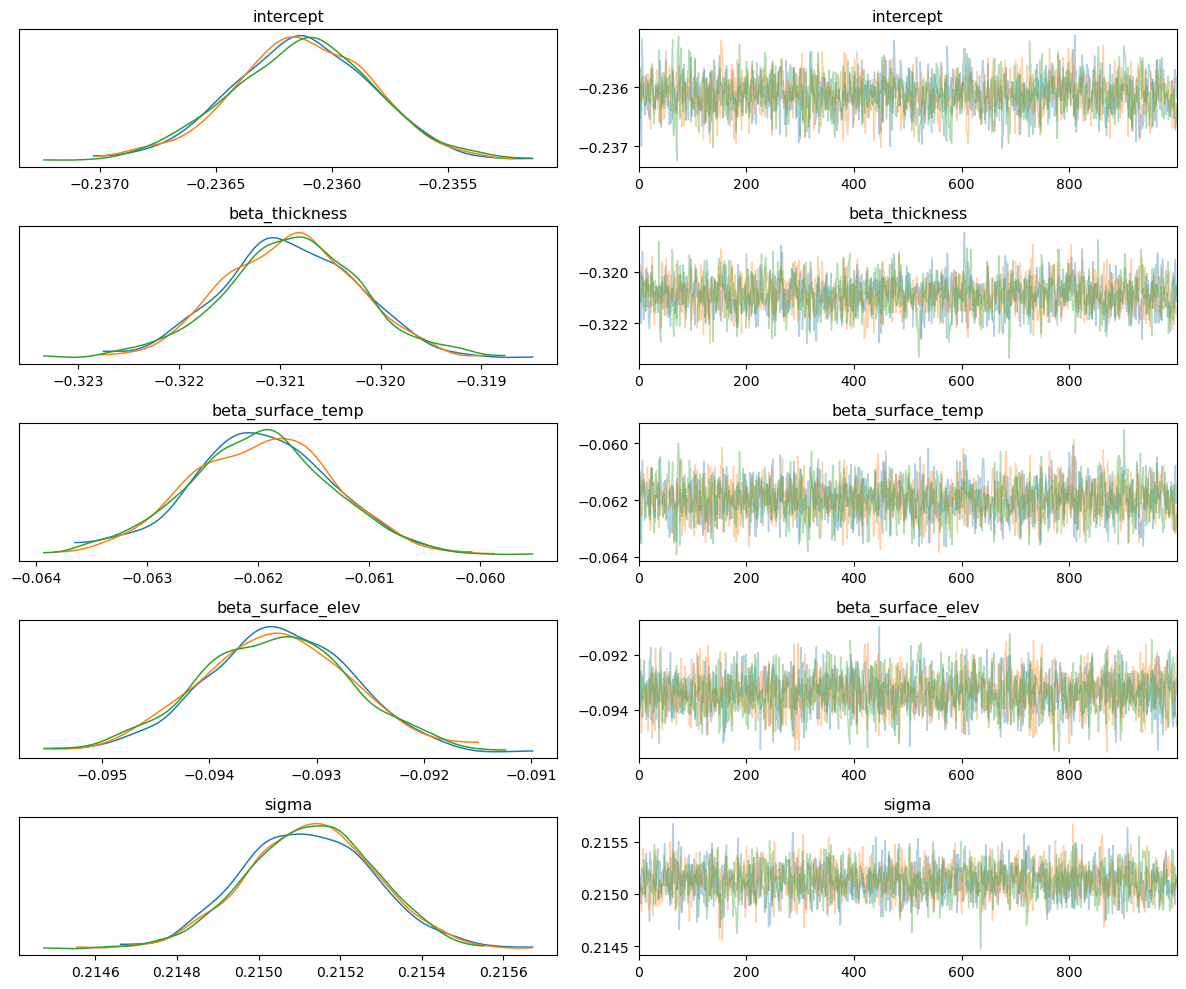

In [43]:
az.plot_trace(gis_trace, 
              var_names=['intercept', 'beta_thickness', 
                         'beta_surface_temp', 'beta_surface_elev', 
                         'sigma'], 
              combined=False, compact=False)
plt.tight_layout()

In [44]:
gis_trace.to_netcdf("gis_trace.nc")

'gis_trace.nc'

In [48]:
gis_fit_df=az.summary(gis_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 
                                                           'beta_thickness', 
                                                           'beta_surface_temp',
                                                            'beta_surface_elev', 
                                                            'sigma'], :]

In [49]:
gis_estimate = gis_fit_df['mean']['intercept'] + \
                 gis_fit_df['mean']['beta_thickness']*norm_thickness + \
                 gis_fit_df['mean']['beta_surface_temp']*norm_surf_temp + \
                 gis_fit_df['mean']['beta_surface_elev']*norm_surf_elevation

/tmp/ipykernel_110/3057923489.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


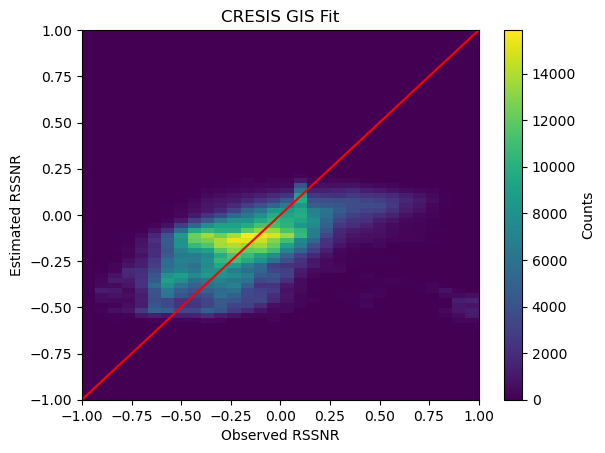

In [50]:
viridis = cm.get_cmap('viridis')
bg_color = viridis(0)  

fig, ax = plt.subplots()
ax.set_facecolor(bg_color)

h = ax.hist2d(norm_snr, gis_estimate, 
              bins=30, cmap='viridis')

ax.plot([-1,1],[-1,1], c='red')

ax.set_ylim([-1,1])

# Add colorbar and labels
plt.colorbar(h[3], ax=ax, label='Counts')

plt.title('CRESIS GIS Fit')
plt.ylabel('Estimated RSSNR')
plt.xlabel('Observed RSSNR');

## Making the Gridded Products

### First on the AIS

In [118]:
floating_trace = az.from_netcdf("saved_traces/texas_floating_trace.nc")

In [22]:
data = xr.open_dataset('input_data_ais.nc')
ais_df = data.to_dataframe()

Fit a scaler to the previous data:

In [26]:
def fit_combo_scaler(x):
    median_x = np.median(x)
    iqr_x = np.percentile(x, 75) - np.percentile(x, 25)
    robust_x = (x - median_x) / iqr_x

    min_robust = np.nanmin(robust_x)
    max_robust = np.nanmax(robust_x)

    scaled_x = ((robust_x - min_robust) / (max_robust - min_robust)) * 2 - 1

    # Return both scaled data and parameters for future use
    return scaled_x, {
        'median': median_x,
        'iqr': iqr_x,
        'min_robust': min_robust,
        'max_robust': max_robust
    }

In [27]:
def transform_combo_scaler(x_new, params):
    robust_x = (x_new - params['median']) / params['iqr']

    scaled_x = ((robust_x - params['min_robust']) / 
                (params['max_robust'] - params['min_robust'])) * 2 - 1

    return scaled_x

In [86]:
# intercept_posterior = combined_trace.posterior.stack(sample=("chain", "draw"))['intercept']
# beta_thickness_posterior = combined_trace.posterior.stack(sample=("chain", "draw"))['beta_thickness']
# beta_surface_temp_posterior = combined_trace.posterior.stack(sample=("chain", "draw"))['beta_surface_temp']
# beta_surface_elev_posterior = combined_trace.posterior.stack(sample=("chain", "draw"))['beta_surface_elev']

In [78]:
def inverse_combo_scaler(scaled_x, params):
    # Step 1: Undo min-max scaling
    robust_x = ((scaled_x + 1) / 2) * (params['max_robust'] - params['min_robust']) + params['min_robust']

    # Step 2: Undo robust scaling
    original_x = robust_x * params['iqr'] + params['median']

    return original_x

In [109]:
def cdf_ais_grounded_values(dataframe, trace, 
                            combo_thickness, combo_surf_temp, 
                            combo_surf_elevation, combo_snr):

    # define the variables
    thickness = dataframe['thickness']
    surf_temp = dataframe['t2m']
    surf_elevation = dataframe['surface']

    _, scaler_params = fit_combo_scaler(combo_thickness)
    norm_thickness = transform_combo_scaler(thickness, scaler_params)
    
    _, scaler_params = fit_combo_scaler(combo_surf_temp)
    norm_surf_temp = transform_combo_scaler(surf_temp, scaler_params)
    
    _, scaler_params = fit_combo_scaler(combo_surf_elevation)
    norm_surf_elev = transform_combo_scaler(surf_elevation, scaler_params)

    combo_posterior = az.extract(trace)
    combo_quantiles = combo_posterior.quantile([0.025, 0.5, 0.975])

    combo_fit_lower = (
        combo_quantiles['intercept'].sel(quantile=0.025).values +
        combo_quantiles['beta_thickness'].sel(quantile=0.025).values * norm_thickness.values +
        combo_quantiles['beta_surface_temp'].sel(quantile=0.025).values * norm_surf_temp.values +
        combo_quantiles['beta_surface_elev'].sel(quantile=0.025).values * norm_surf_elev.values
    )
    
    combo_fit_median = (
        combo_quantiles['intercept'].sel(quantile=0.5).values +
        combo_quantiles['beta_thickness'].sel(quantile=0.5).values * norm_thickness.values +
        combo_quantiles['beta_surface_temp'].sel(quantile=0.5).values * norm_surf_temp.values +
        combo_quantiles['beta_surface_elev'].sel(quantile=0.5).values * norm_surf_elev.values
    )
    
    combo_fit_upper = (
        combo_quantiles['intercept'].sel(quantile=0.975).values +
        combo_quantiles['beta_thickness'].sel(quantile=0.975).values * norm_thickness.values +
        combo_quantiles['beta_surface_temp'].sel(quantile=0.975).values * norm_surf_temp.values +
        combo_quantiles['beta_surface_elev'].sel(quantile=0.975).values * norm_surf_elev.values
    )

    _, scaler_params = fit_combo_scaler(combo_snr)
    estimated_lower_snr = inverse_combo_scaler(combo_fit_lower, scaler_params)
    estimated_median_snr = inverse_combo_scaler(combo_fit_median, scaler_params)
    estimated_upper_snr = inverse_combo_scaler(combo_fit_upper, scaler_params)

    sorted_indices = np.argsort(combo_fit_median)

    estimated_median_snr = estimated_median_snr[sorted_indices]
    estimated_lower_snr = estimated_lower_snr[sorted_indices]
    estimated_upper_snr = estimated_upper_snr[sorted_indices]

    n = len(estimated_median_snr)
    cdf_y = np.linspace(0, 1, n, endpoint=False)

    return cdf_y, estimated_median_snr, estimated_lower_snr, estimated_upper_snr

In [110]:
grounded_fast_ais = ais_df.loc[(ais_df['mask']==2) & (ais_df['speed']>50)]

In [140]:
ais_fast_cdf, ais_fast_median_snr, ais_fast_lower_snr, ais_fast_upper_snr = cdf_ais_grounded_values(grounded_fast_ais, 
                                                                                                    combined_trace, 
                                                                                                    combo_thickness, 
                                                                                                    combo_surf_temp, 
                                                                                                    combo_surf_elevation,
                                                                                                    combo_snr
                                                                                                   )

In [141]:
grounded_slow_ais = ais_df.loc[(ais_df['mask']==2) & (ais_df['speed']<=50)]

In [142]:
ais_slow_cdf, ais_slow_median_snr, ais_slow_lower_snr, ais_slow_upper_snr = cdf_ais_grounded_values(grounded_slow_ais, 
                                                                                                    combined_trace, 
                                                                                                    combo_thickness, 
                                                                                                    combo_surf_temp, 
                                                                                                    combo_surf_elevation,
                                                                                                    combo_snr
                                                                                                   )

In [125]:
def cdf_ais_floating_values(dataframe, trace, 
                            floating_thickness, floating_log_speed, 
                            floating_surf_elevation, floating_snr):

    # define the variables
    thickness = dataframe['thickness']
    log_speed = np.log(dataframe['speed'])
    surf_elevation = dataframe['surface']

    _, scaler_params = fit_combo_scaler(floating_thickness)
    norm_thickness = transform_combo_scaler(thickness, scaler_params)
    
    _, scaler_params = fit_combo_scaler(floating_log_speed)
    norm_speed = transform_combo_scaler(log_speed, scaler_params)
    
    _, scaler_params = fit_combo_scaler(floating_surf_elevation)
    norm_surf_elev = transform_combo_scaler(surf_elevation, scaler_params)

    floating_posterior = az.extract(trace)
    floating_quantiles = floating_posterior.quantile([0.025, 0.5, 0.975])

    floating_fit_lower = (
        floating_quantiles['intercept'].sel(quantile=0.025).values +
        floating_quantiles['beta_thickness'].sel(quantile=0.025).values * norm_thickness.values +
        floating_quantiles['beta_speed'].sel(quantile=0.025).values * norm_speed.values +
        floating_quantiles['beta_surface_elev'].sel(quantile=0.025).values * norm_surf_elev.values
    )
    
    floating_fit_median = (
        floating_quantiles['intercept'].sel(quantile=0.5).values +
        floating_quantiles['beta_thickness'].sel(quantile=0.5).values * norm_thickness.values +
        floating_quantiles['beta_speed'].sel(quantile=0.5).values * norm_speed.values +
        floating_quantiles['beta_surface_elev'].sel(quantile=0.5).values * norm_surf_elev.values
    )
    
    floating_fit_upper = (
        floating_quantiles['intercept'].sel(quantile=0.975).values +
        floating_quantiles['beta_thickness'].sel(quantile=0.975).values * norm_thickness.values +
        floating_quantiles['beta_speed'].sel(quantile=0.975).values * norm_speed.values +
        floating_quantiles['beta_surface_elev'].sel(quantile=0.975).values * norm_surf_elev.values
    )

    _, scaler_params = fit_combo_scaler(floating_snr)
    estimated_lower_snr = inverse_combo_scaler(floating_fit_lower, scaler_params)
    estimated_median_snr = inverse_combo_scaler(floating_fit_median, scaler_params)
    estimated_upper_snr = inverse_combo_scaler(floating_fit_upper, scaler_params)

    sorted_indices = np.argsort(floating_fit_median)

    estimated_median_snr = estimated_median_snr[sorted_indices]
    estimated_lower_snr = estimated_lower_snr[sorted_indices]
    estimated_upper_snr = estimated_upper_snr[sorted_indices]

    n = len(estimated_median_snr)
    cdf_y = np.linspace(0, 1, n, endpoint=False)

    return cdf_y, estimated_median_snr, estimated_lower_snr, estimated_upper_snr

In [126]:
floating_ais = ais_df.loc[(ais_df['mask']==3)]

In [127]:
floating_cdf, floating_median_snr, floating_lower_snr, floating_upper_snr = cdf_ais_floating_values(floating_ais, 
                                                                                                    floating_trace, 
                                                                                                    thickness, 
                                                                                                    speed, 
                                                                                                    surf_elevation,
                                                                                                    snr
                                                                                                   )

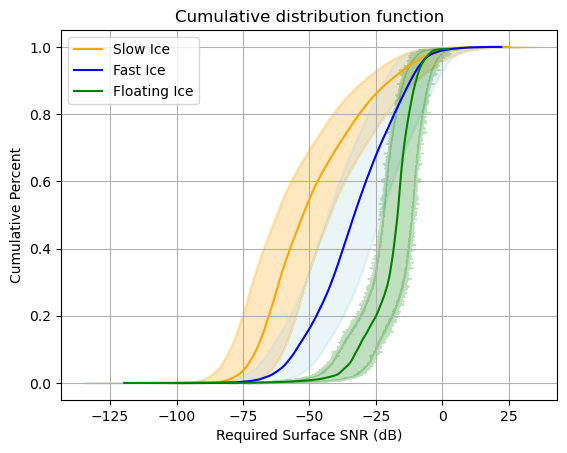

In [146]:
plt.plot(ais_slow_median_snr, ais_slow_cdf, color='orange', label='Slow Ice')
plt.fill_betweenx(ais_slow_cdf, ais_slow_lower_snr-10, ais_slow_upper_snr+10, color='orange', 
                  alpha=0.25, label='')

plt.plot(ais_fast_median_snr, ais_fast_cdf, color='blue', label='Fast Ice')
plt.fill_betweenx(ais_fast_cdf, ais_fast_lower_snr-10, ais_fast_upper_snr+10, color='lightblue', 
                  alpha=0.25, label='')

plt.plot(floating_median_snr, floating_cdf, color='green', label='Floating Ice')
plt.fill_betweenx(floating_cdf, floating_lower_snr-8, floating_upper_snr+8, color='green', 
                  alpha=0.25, label='')

plt.xlabel('Required Surface SNR (dB)')
plt.ylabel('Cumulative Percent')
plt.title('Cumulative distribution function')
plt.legend()
plt.grid(True)
plt.show()

### Next on the GIS

In [155]:
gis_trace = az.from_netcdf("saved_traces/gis_trace.nc")

In [154]:
data = xr.open_dataset('input_data_gis.nc')
gis_df = data.to_dataframe()

In [161]:
def cdf_gis_grounded_values(dataframe, trace, 
                            gis_thickness, gis_surface_temp, 
                            gis_surf_elevation, gis_snr):

    # define the variables
    thickness = dataframe['thickness']
    surf_temp = dataframe['t2m']
    surf_elevation = dataframe['surface']

    _, scaler_params = fit_combo_scaler(gis_thickness)
    norm_thickness = transform_combo_scaler(thickness, scaler_params)
    
    _, scaler_params = fit_combo_scaler(gis_surface_temp)
    norm_surf_temp = transform_combo_scaler(surf_temp, scaler_params)
    
    _, scaler_params = fit_combo_scaler(gis_surf_elevation)
    norm_surf_elev = transform_combo_scaler(surf_elevation, scaler_params)

    gis_posterior = az.extract(trace)
    gis_quantiles = gis_posterior.quantile([0.025, 0.5, 0.975])

    gis_fit_lower = (
        gis_quantiles['intercept'].sel(quantile=0.025).values +
        gis_quantiles['beta_thickness'].sel(quantile=0.025).values * norm_thickness.values +
        gis_quantiles['beta_surface_temp'].sel(quantile=0.025).values * norm_surf_temp.values +
        gis_quantiles['beta_surface_elev'].sel(quantile=0.025).values * norm_surf_elev.values
    )
    
    gis_fit_median = (
        gis_quantiles['intercept'].sel(quantile=0.5).values +
        gis_quantiles['beta_thickness'].sel(quantile=0.5).values * norm_thickness.values +
        gis_quantiles['beta_surface_temp'].sel(quantile=0.5).values * norm_surf_temp.values +
        gis_quantiles['beta_surface_elev'].sel(quantile=0.5).values * norm_surf_elev.values
    )
    
    gis_fit_upper = (
        gis_quantiles['intercept'].sel(quantile=0.975).values +
        gis_quantiles['beta_thickness'].sel(quantile=0.975).values * norm_thickness.values +
        gis_quantiles['beta_surface_temp'].sel(quantile=0.975).values * norm_surf_temp.values +
        gis_quantiles['beta_surface_elev'].sel(quantile=0.975).values * norm_surf_elev.values
    )

    _, scaler_params = fit_combo_scaler(gis_snr)
    estimated_lower_snr = inverse_combo_scaler(gis_fit_lower, scaler_params)
    estimated_median_snr = inverse_combo_scaler(gis_fit_median, scaler_params)
    estimated_upper_snr = inverse_combo_scaler(gis_fit_upper, scaler_params)

    sorted_indices = np.argsort(gis_fit_median)

    estimated_median_snr = estimated_median_snr[sorted_indices]
    estimated_lower_snr = estimated_lower_snr[sorted_indices]
    estimated_upper_snr = estimated_upper_snr[sorted_indices]

    n = len(estimated_median_snr)
    cdf_y = np.linspace(0, 1, n, endpoint=False)

    return cdf_y, estimated_median_snr, estimated_lower_snr, estimated_upper_snr

In [162]:
grounded_fast_gis = gis_df.loc[(gis_df['mask']==2) & (gis_df['speed']>50)]

In [163]:
gis_fast_cdf, gis_fast_median_snr, gis_fast_lower_snr, gis_fast_upper_snr = cdf_gis_grounded_values(grounded_fast_gis, 
                                                                                                    gis_trace, 
                                                                                                    gis_thickness, 
                                                                                                    gis_surf_temp, 
                                                                                                    gis_surf_elevation,
                                                                                                    gis_snr
                                                                                                   )

In [164]:
grounded_slow_gis = gis_df.loc[(gis_df['mask']==2) & (gis_df['speed']<=50)]

In [165]:
gis_slow_cdf, gis_slow_median_snr, gis_slow_lower_snr, gis_slow_upper_snr = cdf_gis_grounded_values(grounded_slow_gis, 
                                                                                                    gis_trace, 
                                                                                                    gis_thickness, 
                                                                                                    gis_surf_temp, 
                                                                                                    gis_surf_elevation,
                                                                                                    gis_snr
                                                                                                   )

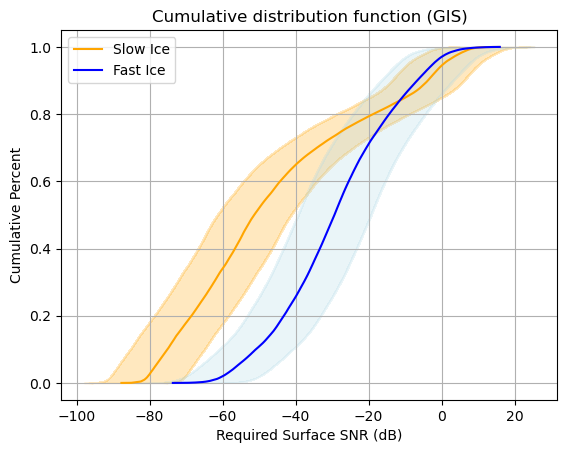

In [168]:
plt.plot(gis_slow_median_snr, gis_slow_cdf, color='orange', label='Slow Ice')
plt.fill_betweenx(gis_slow_cdf, gis_slow_lower_snr-10, gis_slow_upper_snr+10, color='orange', 
                  alpha=0.25, label='')

plt.plot(gis_fast_median_snr, gis_fast_cdf, color='blue', label='Fast Ice')
plt.fill_betweenx(gis_fast_cdf, gis_fast_lower_snr-10, gis_fast_upper_snr+10, color='lightblue', 
                  alpha=0.25, label='')


plt.xlabel('Required Surface SNR (dB)')
plt.ylabel('Cumulative Percent')
plt.title('Cumulative distribution function (GIS)')
plt.legend()
plt.grid(True)
plt.show()